In [1]:
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from mothur_py import Mothur
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")

import re

_nsre = re.compile('([0-9]+)')
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)] 

In [13]:
fastq_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Concatenated/20171103_FAH15473/barcode02/merged.fastq", "fastq"))

In [ ]:
lengths = []
for key in fastq_dict:
    lengths.append(len(fastq_dict[key].seq))
print("The number of reads in this file is", len(fastq_dict))
ax = sns.distplot(lengths, color="k", kde=False, bins=5000)


ax.set(xlim=(250, 3500))
ax.set_title("Reads spread 20171103_FAH15473/barcode02", fontsize=15)
ax.set_xlabel("Length of read", fontsize=13)
ax.set_ylabel("Number of reads", fontsize=13)

plt.show()

In [28]:
frDNA = fastq_dict.copy()
for key in fastq_dict:
    if len(fastq_dict[key].seq) not in range(2700, 3200):
        del frDNA[key]
print("The number of reads between 2700 and 3200 bp in length is", len(frDNA))
EF1a = fastq_dict.copy()
for key in fastq_dict:
    if len(fastq_dict[key].seq) not in range(900, 1400):
        del EF1a[key]
print("The number of reads between 900 and 1400 bp in length is", len(EF1a))

The number of reads between 2700 and 3200 bp in length is 167054
The number of reads between 900 and 1400 bp in length is 192712


In [29]:
# Write the reads defined between the frDNA cutoff into a new fasta file
SeqIO.write(frDNA.values(), "../../analysis/Python_Processing/20171103_FAH15473/barcode02/barcode02_frDNA_clipped.fastq", "fastq")

167054

In [30]:
# Write the reads defined between the EF1a cutoff into a new fasta file
SeqIO.write(EF1a.values(), "../../analysis/Python_Processing/20171103_FAH15473/barcode02/barcode02_EF1a_clipped.fastq", "fastq")

192712

In [31]:
frDNA_extract={k: frDNA[k] for k in list(frDNA.keys())[:500]}
EF1a_extract={k: EF1a[k] for k in list(EF1a.keys())[:500]}

In [32]:
for key in frDNA_extract:
    frDNA_extract[key].annotations = 'frDNA'
for key in EF1a_extract:
    EF1a_extract[key].annotations = 'EF1a'

In [33]:
combined_extract = {}
combined_extract.update(frDNA_extract)
combined_extract.update(EF1a_extract)
print(len(frDNA_extract))
print(len(EF1a_extract))
print(len(combined_extract))

500
500
1000


In [34]:
SeqIO.write(frDNA_extract.values(), "../../analysis/Python_Processing/20171103_FAH15473/barcode02/barcode02_frDNA_extract_test.fastq", "fastq")
SeqIO.write(EF1a_extract.values(), "../../analysis/Python_Processing/20171103_FAH15473/barcode02/barcode02_EF1a_extract_test.fastq", "fastq")
SeqIO.write(combined_extract.values(), "../../analysis/Python_Processing/20171103_FAH15473/barcode02/barcode02_combined_extract_test.fastq", "fastq")

1000

In [35]:
frDNA_paf = pd.read_csv("../../analysis/Python_Processing/20171103_FAH15473/barcode02/frDNA_clipped_test.paf", sep='\t', header=None, engine='python')
EF1a_paf = pd.read_csv("../../analysis/Python_Processing/20171103_FAH15473/barcode02/EF1a_clipped_test.paf", sep='\t', header=None, engine='python')
combined_paf = pd.read_csv("../../analysis/Python_Processing/20171103_FAH15473/barcode02/combined_test.paf", sep='\t', header=None, engine='python')

In [36]:
frDNA_paf.head()

0     1     2     3  4   \
0  11765199-a559-412c-9c2d-992dead3d782  2912  1945  2574  +   
1  e72814ef-ec58-42da-8d8f-59c40d51d6bf  2951  1449  1784  +   
2  2f569c0e-ef7d-48a1-a215-5a35e14ae35b  2906  1141  1458  -   
3  2f569c0e-ef7d-48a1-a215-5a35e14ae35b  2906   322  1815  -   
4  2f569c0e-ef7d-48a1-a215-5a35e14ae35b  2906  1351  1458  -   

                              5     6     7     8    9     10  11      12  \
0         Kluyveromyces|KT853036  1778  1110  1752   72   646  47  tp:A:P   
1          Zymoseptoria|KM246156   484   118   444   76   335  60  tp:A:P   
2          Zymoseptoria|KM246156   484   134   451   81   328  17  tp:A:P   
3         Kluyveromyces|KT853036  1778   100  1752  105  1654  60  tp:A:P   
4  Oculimacula(Tapesia)|AY713294   608   260   368   66   109   0  tp:A:S   

       13       14           15           16  
0  cm:i:7  s1:i:68       s2:i:0  dv:f:0.1860  
1  cm:i:8  s1:i:75       s2:i:0  dv:f:0.1354  
2  cm:i:7  s1:i:77      s2:i:66  dv:f:0.1421  
3  cm:i:9  s1:i:76       s2:i:0  dv:f:0.2270  
4  cm:i:6  s1:i:66  dv:f:0.0835         None

In [37]:
combined_paf.head()

0     1     2     3  4   \
0  11765199-a559-412c-9c2d-992dead3d782  2912  1945  2574  +   
1  e72814ef-ec58-42da-8d8f-59c40d51d6bf  2951  1449  1784  +   
2  2f569c0e-ef7d-48a1-a215-5a35e14ae35b  2906  1141  1458  -   
3  2f569c0e-ef7d-48a1-a215-5a35e14ae35b  2906   322  1815  -   
4  2f569c0e-ef7d-48a1-a215-5a35e14ae35b  2906  1351  1458  -   

                              5     6     7     8    9     10  11      12  \
0         Kluyveromyces|KT853036  1778  1110  1752   72   646  47  tp:A:P   
1          Zymoseptoria|KM246156   484   118   444   76   335  60  tp:A:P   
2          Zymoseptoria|KM246156   484   134   451   81   328  17  tp:A:P   
3         Kluyveromyces|KT853036  1778   100  1752  105  1654  60  tp:A:P   
4  Oculimacula(Tapesia)|AY713294   608   260   368   66   109   0  tp:A:S   

       13       14           15           16  
0  cm:i:7  s1:i:68       s2:i:0  dv:f:0.1860  
1  cm:i:8  s1:i:75       s2:i:0  dv:f:0.1354  
2  cm:i:7  s1:i:77      s2:i:66  dv:f:0.1421  
3  cm:i:9  s1:i:76       s2:i:0  dv:f:0.2270  
4  cm:i:6  s1:i:66  dv:f:0.0835         None

In [38]:
print("min len of match for frDNA is", frDNA_paf[1].min())
print("min len of match for EF1a is", EF1a_paf[1].min())
print("min len of match for combined is", combined_paf[1].min())

min len of match for frDNA is 2700
min len of match for EF1a is 900
min len of match for combined is 284


In [39]:
print('num matches with unique ids for frDNA is', len(frDNA_paf[0].unique()))
print('num matches with unique ids for EF1a is', len(EF1a_paf[0].unique()))
print('num matches with unique ids for combined is', len(combined_paf[0].unique()))

num matches with unique ids for frDNA is 123026
num matches with unique ids for EF1a is 2124
num matches with unique ids for combined is 143363


Compare above (using minimap2) with BLAST approach
    - BLAST may be too slow on a larger dataset


Check with other alignment programs eg. lastz, BLAT (check for others)



# Testing of full size-clipped files for alignment via minimap2
 - For each of the frDNA_clipped and EF1a_clipped files as created above 
     - Look for the number of unique ids in the resultant file
     - Determine the percentage of reads in this range that match homology given total number of reads in the clipped.fastq file

In [40]:
frDNA_clipped_paf = pd.read_csv("../../analysis/Python_Processing/20171103_FAH15473/barcode02/frDNA_clipped_test.paf", sep='\t', header=None, engine='python')

In [41]:
EF1a_clipped_paf = pd.read_csv("../../analysis/Python_Processing/20171103_FAH15473/barcode02/EF1a_clipped_test.paf", sep='\t', header=None)

In [42]:
print('Total number of matches found for frDNA is', len(frDNA_clipped_paf[0].unique()))
print('Percentage of matches in region =', "{:.3%}".format((len(frDNA_clipped_paf[0].unique())/167054)))

Total number of matches found for frDNA is 123026
Percentage of matches in region = 73.644%


In [43]:
print('Total number of matches found for EF1a is', len(EF1a_clipped_paf[0].unique()))
print('False positive percentage =', "{:.3%}".format((len(EF1a_clipped_paf[0].unique())/192712)))

Total number of matches found for EF1a is 2124
False positive percentage = 1.102%


In [44]:
print('Total number of matches found for the total of reads is', len(combined_paf[0].unique()))
print('Percentage of matches overall =', "{:.3%}".format((len(combined_paf[0].unique())/413127)))

Total number of matches found for the total of reads is 143363
Percentage of matches overall = 34.702%


~~Plot distribution of matching reads as above~~

~~Repeat minimap2 for above to see if fluctuations~~

Explore non-mapping 25%

Scaling - plots saved out, file for statistics (loop over later)

In [45]:
# combined_ids = []
# for key in combined_paf[0].unique():
#     combined_ids.append(key)
combined_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Concatenated/20171103_FAH15473/barcode02/merged.fastq", "fastq"))
comb_dict = {}
for key in combined_paf[0].unique():
    comb_dict[key] = combined_dict[key]

In [46]:
lengths = []
comb_keys = []
for key in comb_dict:
    lengths.append(len(comb_dict[key].seq))
    comb_keys.append(key)

mean = np.mean(lengths)
std = np.std(lengths)
print(mean)
print(std)
    
# stats_dict = {'number of frDNA reads':len(lengths),'minimum read length':min(lengths),'maximum read length':max(lengths),'mean read length':"{:.0f}".format(np.mean(lengths)),'median read length':"{:.0f}".format(np.median(lengths))}
# stats = pd.DataFrame(stats_dict, index=['20171103_FAH15473/barcode02'])
        
              
# ax = sns.distplot(lengths, color="k", kde=False, bins=5000)
# ax.set(xlim=(250, 3500))
# ax.set_title("frDNA reads for 20171103_FAH15473/barcode02", fontsize=15)
# ax.set_xlabel("Length of read", fontsize=13)
# ax.set_ylabel("Number of reads", fontsize=13)
# plt.show()


# ax = sns.distplot(lengths, color="k", kde=False, bins=5000)
# ax.set(xlim=(2400, 3500))
# ax.set_title("frDNA reads for 20171103_FAH15473/barcode02", fontsize=15)
# ax.set_xlabel("Length of read", fontsize=13)
# ax.set_ylabel("Number of reads", fontsize=13)
# plt.show()


# display(stats)

2780.2827926312925
431.00582247556844


In [47]:
fr_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Python_Processing/20171103_FAH15473/barcode02/barcode02_frDNA_clipped.fastq", 'fastq'))
print(len(fr_dict))

167054


In [ ]:
# non_dict = {}
# for key in fr_dict:
#     if key not in frDNA_clipped_paf[0].unique():
#         non_dict[key] = fr_dict[key]
# print(len(non_dict))

In [ ]:
# lengths = []
# non_keys = []
# for key in non_dict:
#     lengths.append(len(non_dict[key].seq))
#     non_keys.append(key)

# non_dict_stats = {'number of reads':len(lengths),'minimum read length':min(lengths),'maximum read length':max(lengths),'mean read length':"{:.0f}".format(np.mean(lengths)),'median read length':"{:.0f}".format(np.median(lengths))}
# stats = pd.DataFrame(non_dict_stats, index=['20171103_FAH15473/barcode02'])
        
              
# ax = sns.distplot(lengths, color="k", kde=False)
# # ax.set(xlim=(250, 3500))
# ax.set_title("non-frDNA reads for 20171103_FAH15473/barcode02", fontsize=15)
# ax.set_xlabel("Length of read", fontsize=13)
# ax.set_ylabel("Number of reads", fontsize=13)
# plt.show()
# display(stats)

In [ ]:
%%writefile ../summary_statistics.py

"""
The goal of this program is to examine the distribution of reads within
each file, and for the files generated after homology analysis.
The program will generate summary statistics for the result of the homology
analysis and save figures illustrating the read distribution for the
frDNA reads
"""

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import matplotlib.pyplot as plt
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
The goal of this program is to examine the distribution of reads within
each file, and for the files generated after homology analysis.
The program will generate summary statistics for the result of the homology
analysis and save figures illustrating the read distribution for the
frDNA reads
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("full_file", help="The full, unfiltered file containing all reads for this barcode")
parser.add_argument("input_folder", help="The destination folder within which the .paf files are generated")
parser.add_argument("output_folder", help="The destination folder for any outputs from this script - including summary statistics file and plots")
args = parser.parse_args()

print('\033[0;35m'+'START'+'\033[1;37m')

output_folder = args.output_folder.rsplit('/', 1)[-2]
input_folder = args.input_folder.rsplit('/', 1)[-2]
if args.verbose:
    print('\033[0;31m' + "Input folder is " + input_folder + '\033[1;37m')
    print('\033[0;31m' + "Output folder is " + output_folder + '\033[1;37m')
    print('\033[0;34m' + "Loading " + args.full_file + '\033[1;37m')

# Load the full file containing all reads for this barcode
full_file_dict = SeqIO.to_dict(SeqIO.parse(args.full_file, "fastq"))

if args.verbose:
    print('\033[0;34m' + "Loaded " + args.full_file + '\033[1;37m')

# Extract the information about the lengths of the sequence for each read in this barcode
full_lengths = []
for key in full_file_dict:
    full_lengths.append(len(full_file_dict[key].seq))
full_lengths_len = len(full_file_dict)


# Plot the spread of read lengths for this barcode
    # Expect to see two peaks - one for EF1a and one for frDNA
ax = sns.distplot(full_lengths, color="k", kde=False, bins=5000)
ax.set(xlim=(250, 3500))
ax.set_title("Read spread for %s" % '/'.join(args.full_file.rsplit('/')[-3:-1]), fontsize=15)
ax.set_xlabel("Length of read", fontsize=13)
ax.set_ylabel("Number of reads", fontsize=13)
figure1 = ax.get_figure()
# Save this figure out
figure1.savefig('/'.join([output_folder, 'full_read_spread.png']))
figure1.clf()
if args.verbose:
    print('\033[0;32m' + "Full spread image file saved to " + '/'.join([output_folder, 'full_read_spread.png']) + '\033[1;37m')
    print('\033[0;34m' + "Loading " + input_folder+"/combined_test.paf" + '\033[1;37m')

# Import the PAF file resulting from the minimap2 homology filtering
full_paf = pd.read_csv(input_folder+"/combined_test.paf", sep='\t', header=None, engine='python')
if args.verbose:
    print('\033[0;34m' + "Loaded " + input_folder+"/combined_test.paf" + '\033[1;37m')
# Determine all the read ids present within the homology-filtered dataset
# Then, create a dictionary extracting all the information from the full read file, but ONLY for reads present within the homology-filtered data
full_dict = {}
for key in full_paf[0].unique():
    full_dict[key] = full_file_dict[key]

# For each key in the homology-filtered dictionary, extract the sequence length and key
full_paf_lengths = []
full_keys = []
for key in full_dict:
    full_paf_lengths.append(len(full_dict[key].seq))
    full_keys.append(key)

mean = np.mean(full_paf_lengths)
std = np.std(full_paf_lengths)

if args.verbose:
    print('\033[1;33m' + 'Mean read length is %s' % mean + '\033[1;37m')
    print('\033[1;33m' + 'Standard deviation of read length is %s' % std + '\033[1;37m')
    
    
length_filt_dict = full_dict.copy()
for key in full_keys:
    if len(full_dict[key].seq) < (mean-1.645*std) or len(full_dict[key].seq) > (mean+1.645*std):
        del length_filt_dict[key]

        
        
SeqIO.write(length_filt_dict.values(), '/'.join([output_folder, 'length_restricted_reads.fasta']), "fasta")
if args.verbose:
    print('\033[1;36m' + 'Saved %s' % ('/'.join([output_folder, 'length_restricted_reads.fasta'])) + '\033[1;37m')     
    
    
    
length_filt_lens = []
len_filt_keys = []
for key in length_filt_dict:
    length_filt_lens.append(len(length_filt_dict[key].seq))
    len_filt_keys.append(key)

    
    


    
Extract the qscores
if args.verbose:
    print('\033[0;34m' + "Loading " + 'Basecalled/'+'/'.join(args.full_file.rsplit('/')[-3:-1])+'/sequencing_summary.txt' + '\033[1;37m')
summ_stats_csv = pd.read_csv('Basecalled/'+'/'.join(args.full_file.rsplit('/')[-3:-1])+'/sequencing_summary.txt', sep='\t', header=None, names=['filename', 'read_id', 'run_id', 'batch_id', 'channel', 'mux', 'start_time', 'duration', 'num_events', 'passes_filtering', 'template_start', 'num_events_template', 'template_duration', 'sequence_length_template', 'mean_qscore_template', 'strand_score_template', 'median_template', 'mad_template'], engine='python')
summ_stats_csv = pd.DataFrame(summ_stats_csv[1:])
summary_list = []
for column, row in summ_stats_csv.iterrows():
    if row['read_id'] in full_keys:
        summary_list.append([row['read_id'], row['mean_qscore_template']])
summary_frame = pd.DataFrame(summary_list)
if args.verbose:
    print('\033[0;34m' + "Finished with " + 'Basecalled/'+'/'.join(args.full_file.rsplit('/')[-3:-1])+'/sequencing_summary.txt' + '\033[1;37m')
    
Create a dictionary containing the statistics for the filtered dataset
    Total no. frDNA reads, Min. read length, Max. read length, Mean read length, Median read length, Quality score

stats_dict = {'number of frDNA reads':len(length_filt_lens),'minimum read length':min(length_filt_lens),'maximum read length':max(length_filt_lens),'mean read length':"{:.0f}".format(np.mean(length_filt_lens)),'std dev':"{:.0f}".format(np.std(length_filt_lens)),'median read length':"{:.0f}".format(np.median(length_filt_lens))
              ,'min_qscore':"{:.2f}".format(min(summary_frame[1].astype(float))), 'max_qscore':"{:.2f}".format(max(summary_frame[1].astype(float))), 'mean_qscore':"{:.2f}".format(np.mean(summary_frame[1].astype(float))), 'median_qscore':"{:.2f}".format(np.median(summary_frame[1].astype(float)))
             }
stats = pd.DataFrame(stats_dict, index=['%s' % '/'.join(args.full_file.rsplit('/')[-3:-1])])    
              
bx = sns.distplot(length_filt_lens, color="k", kde=False)
bx.set(xlim=(250, 3500))
bx.set_title("frDNA reads for %s" % '/'.join(args.full_file.rsplit('/')[-3:-1]), fontsize=15)
bx.set_xlabel("Length of read", fontsize=13)
bx.set_ylabel("Number of reads", fontsize=13)
figure2 = bx.get_figure()
figure2.savefig('/'.join([output_folder, 'frDNA_len_filt_full.png']))
figure2.clf()
if args.verbose:
    print('\033[0;32m' + "frDNA spread image file saved to " + '/'.join([output_folder, 'frDNA_len_filt_full.png']) + '\033[1;37m')

cx = sns.distplot(length_filt_lens, color="k", kde=False)
cx.set(xlim=((mean-1.645*std)-100, (mean+1.645*std)+100))
cx.set_title("frDNA reads for %s" % '/'.join(args.full_file.rsplit('/')[-3:-1]), fontsize=15)
cx.set_xlabel("Length of read", fontsize=13)
cx.set_ylabel("Number of reads", fontsize=13)
figure3 = cx.get_figure()
figure3.savefig('/'.join([output_folder, 'frDNA_len_filt_limited.png']))
figure3.clf()
if args.verbose:
    print('\033[0;32m' + "Zoomed-in frDNA spread image file saved to " + '/'.join([output_folder, 'frDNA_len_filt_limited.png']) + '\033[1;37m')

stats.to_csv('/'.join([output_folder, 'frDNA_len_filt_statistics.csv']), index=False)
if args.verbose:
    print('\033[0;32m' + "Summary statistics file saved to " + '/'.join([output_folder, 'frDNA_len_filt_statistics.csv']) + '\033[1;37m')
    
print('\033[0;35m'+'END'+'\033[1;37m')

In [48]:
import glob
path = "/media/MassStorage/tmp/TE/honours/analysis/Stats/*/*/frDNA_statistics.csv"
path_names = glob.glob(path)
full_stats = pd.DataFrame(data=None, columns = ['number of frDNA reads','minimum read length','maximum read length','mean read length','standard deviation','median read length','min_qscore','max_qscore','mean_qscore','median_qscore'])
for path in path_names:
    if path[67:-21] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            path_stats_csv = pd.read_csv(path, header=0)
            print(path_stats_csv)
            full_stats = full_stats.append(path_stats_csv)
            full_stats = full_stats.rename(index={0: path[49:-21]})
full_stats = full_stats.sort_index(ascending=True)
full_stats.to_csv('../../analysis/Stats/overall_frDNA_stats.csv')
num_read_stats = pd.DataFrame(data=["{:.0f}".format(min(full_stats['number of frDNA reads'])), "{:.0f}".format(max(full_stats['number of frDNA reads'])), "{:.0f}".format(np.mean(full_stats['number of frDNA reads'])), "{:.0f}".format(np.median(full_stats['number of frDNA reads']))], index=['Min', 'Max', 'Mean', 'Median'], columns=['Number of reads'])
num_read_stats.to_csv('../../analysis/Stats/number_of_frDNA_reads_summary.csv')
full_stats

   number of frDNA reads  minimum read length  maximum read length  \
0                  32847                  410                 7204   

   mean read length  median read length  min_qscore  max_qscore  mean_qscore  \
0              2782                2872        4.11       12.75         8.06   

   median_qscore  
0           8.01  
   number of frDNA reads  minimum read length  maximum read length  \
0                  33941                  366                 6563   

   mean read length  median read length  min_qscore  max_qscore  mean_qscore  \
0              3123                3255        4.35       12.89         7.84   

   median_qscore  
0           7.79  
   number of frDNA reads  minimum read length  maximum read length  \
0                  33438                  343                89027   

   mean read length  median read length  min_qscore  max_qscore  mean_qscore  \
0              2797                2874         4.5       12.87         8.07   

   median_qscore  

   number of frDNA reads  minimum read length  maximum read length  \
0                  27694                  346               130596   

   mean read length  median read length  min_qscore  max_qscore  mean_qscore  \
0              2413                2479        3.68       13.98         8.58   

   median_qscore  
0           8.46  
   number of frDNA reads  minimum read length  maximum read length  \
0                  40257                  272                43657   

   mean read length  median read length  min_qscore  max_qscore  mean_qscore  \
0              2674                2788        3.62       13.86         8.41   

   median_qscore  
0           8.29  
   number of frDNA reads  minimum read length  maximum read length  \
0                  33025                  346                11279   

   mean read length  median read length  min_qscore  max_qscore  mean_qscore  \
0              2958                3111        4.03       14.51         8.39   

   median_qscore  

max_qscore maximum read length mean read length  \
20171103_FAH15473/barcode01       13.51               97070             2923   
20171103_FAH15473/barcode02       12.86               35613             2780   
20171103_FAH15473/barcode03       12.75                8026             2817   
20171103_FAH15473/barcode04       12.80               13685             2805   
20171103_FAH15473/barcode05       13.44               37598             3130   
20171103_FAH15473/barcode06       12.98               13810             2936   
20171103_FAH15473/barcode07       12.44               13781             2781   
20171103_FAH15473/barcode08       12.84                9932             2571   
20171103_FAH15473/barcode09       12.89               65305             2914   
20171103_FAH15473/barcode10       12.39                8725             2806   
20171103_FAH15473/barcode11       12.98               72305             2841   
20171103_FAH15473/barcode12       13.20               10639             2814   
20171207_FAH18654/barcode01       14.72                7240             2775   
20171207_FAH18654/barcode02       14.54                9882             2848   
20171207_FAH18654/barcode03       13.29                5562             2553   
20171207_FAH18654/barcode04       13.68               15102             2528   
20171207_FAH18654/barcode05       13.84                9065             2823   
20171207_FAH18654/barcode06       14.39                7211             2835   
20171207_FAH18654/barcode07       14.18               12857             2822   
20171207_FAH18654/barcode08       13.96                9453             2817   
20171207_FAH18654/barcode09       14.22                6173             2471   
20171207_FAH18654/barcode11       14.37               18585             2816   
20171207_FAH18654/barcode12       13.72                6957             2844   
20171212_FAH18688/barcode01       13.12               33191             2826   
20171212_FAH18688/barcode02       12.53               65851             2780   
20171212_FAH18688/barcode03       12.75                7204             2782   
20171212_FAH18688/barcode04       14.02                9808             2784   
20171212_FAH18688/barcode05       12.89               15719             2836   
20171212_FAH18688/barcode06       12.69               21224             3177   
20171212_FAH18688/barcode07       12.92               11428             2775   
20171212_FAH18688/barcode08       12.91                9314             2863   
20171212_FAH18688/barcode09       12.89                6563             3123   
20171212_FAH18688/barcode11       13.05               43622             2771   
20171212_FAH18688/barcode12       12.87               89027             2797   
20180108_FAH18647/barcode01       14.51               11279             2958   
20180108_FAH18647/barcode02       13.52                8506             2805   
20180108_FAH18647/barcode03       13.93              156710             2651   
20180108_FAH18647/barcode04       13.86               43657             2674   
20180108_FAH18647/barcode05       15.20               24615             2652   
20180108_FAH18647/barcode06       13.76                9766             2685   
20180108_FAH18647/barcode07       14.24               12563             2683   
20180108_FAH18647/barcode08       13.98              130596             2413   
20180108_FAH18647/barcode09       13.90               19238             2710   
20180108_FAH18647/barcode10       14.06                7971             2819   
20180108_FAH18647/barcode11       13.44                7063             2697   
20180108_FAH18647/barcode12       14.22               14425             2598   

                             mean_qscore median read length  median_qscore  \
20171103_FAH15473/barcode01         7.73               3044           7.71   
20171103_FAH15473/barcode02         7.87               2876           7.86   
20171103_FAH15473/barcode03       

In [45]:
print(sum(full_stats['number of frDNA reads']))

2643652


In [ ]:
import glob
path = "/10tb/tmp/TE/honours/analysis/Length_Filtered/*/*/*.csv"
path_names = glob.glob(path)
full_stats2 = pd.DataFrame(data=None, columns = ['number of frDNA reads','minimum read length','maximum read length','mean read length','standard deviation','median read length'])
for path in path_names:
    if path[64:-30] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            path_stats_csv = pd.read_csv(path, header=0)
            full_stats2 = full_stats2.append(path_stats_csv)
            full_stats2 = full_stats2.rename(index={0: path[46:-30]})
full_stats2 = full_stats2.sort_index(ascending=True)
display(full_stats2)
full_stats2.to_csv('../../analysis/Length_Filtered/overall_frDNA_stats.csv')
num_read_stats = pd.DataFrame(data=["{:.0f}".format(min(full_stats2['number of frDNA reads'])), "{:.0f}".format(max(full_stats2['number of frDNA reads'])), "{:.0f}".format(np.mean(full_stats2['number of frDNA reads'])), "{:.0f}".format(np.median(full_stats2['number of frDNA reads']))], index=['Min', 'Max', 'Mean', 'Median'], columns=['Number of reads'])
num_read_stats.to_csv('../../analysis/Length_Filtered/number_of_frDNA_reads_summary.csv')

#### Create matrix for loss-of-reads when performing length filtering as percentage

In [51]:
full_stats_1 = []
full_stats_2 = []
result = []

for i in full_stats['number of frDNA reads']:
    full_stats_1.append(i)
for i in full_stats2['number of frDNA reads']:
    full_stats_2.append(i)
for i in range (0,len(full_stats_1)):
    result.append(float("{:.2f}".format((full_stats_1[i]-full_stats_2[i])/full_stats_1[i])))
print(result)
print('The maximum loss of reads is %s%% in %s' % (100*max(result), path_names[result.index(max(result))][46:-30]))
print('The minimum loss of reads is %s%% in %s' % (100*min(result), path_names[result.index(min(result))][46:-30]))

[0.07, 0.07, 0.08, 0.06, 0.08, 0.09, 0.09, 0.07, 0.07, 0.07, 0.08, 0.09, 0.06, 0.07, 0.08, 0.06, 0.07, 0.07, 0.06, 0.06, 0.06, 0.07, 0.05, 0.07, 0.07, 0.07, 0.06, 0.07, 0.07, 0.06, 0.07, 0.08, 0.06, 0.04, 0.08, 0.08, 0.02, 0.07, 0.08, 0.08, 0.09, 0.02, 0.08, 0.09, 0.07, 0.09]
The maximum loss of reads is 9.0% in 20171212_FAH18688/barcode11
The minimum loss of reads is 2.0% in 20180108_FAH18647/barcode06


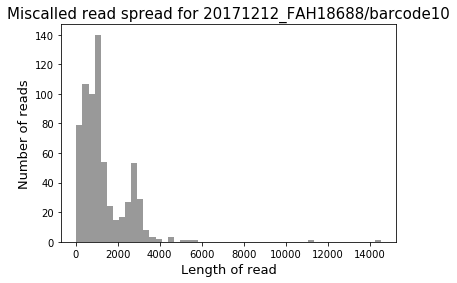

number of reads  minimum read length  \
20171212_FAH18688/barcode10              666                   30   

                             maximum read length mean read length  \
20171212_FAH18688/barcode10                14534             1312   

                            median read length  
20171212_FAH18688/barcode10               1046

In [18]:
FAH18688_barcode10 = SeqIO.to_dict(SeqIO.parse("../../analysis/Concatenated/20171212_FAH18688/barcode10/merged.fastq", 'fastq'))
lengths = []
b10_keys = []
for key in FAH18688_barcode10:
    lengths.append(len(FAH18688_barcode10[key].seq))
    b10_keys.append(key)

non_dict_stats = {'number of reads':len(lengths),'minimum read length':min(lengths),'maximum read length':max(lengths),'mean read length':"{:.0f}".format(np.mean(lengths)),'median read length':"{:.0f}".format(np.median(lengths))}
stats = pd.DataFrame(non_dict_stats, index=['20171212_FAH18688/barcode10'])
              
ax = sns.distplot(lengths, color="k", kde=False)
# ax.set(xlim=(250, 3500))
ax.set_title("Miscalled read spread for 20171212_FAH18688/barcode10", fontsize=15)
ax.set_xlabel("Length of read", fontsize=13)
ax.set_ylabel("Number of reads", fontsize=13)
plt.show()
display(stats)

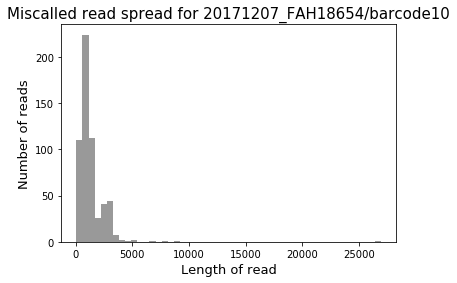

number of reads  minimum read length  \
20171207_FAH18654/barcode10              573                   52   

                             maximum read length mean read length  \
20171207_FAH18654/barcode10                26936             1336   

                            median read length  
20171207_FAH18654/barcode10               1039

In [17]:
FAH18654_barcode10 = SeqIO.to_dict(SeqIO.parse("../../analysis/Concatenated/20171207_FAH18654/barcode10/merged.fastq", 'fastq'))
lengths = []
b10_keys = []
for key in FAH18654_barcode10:
    lengths.append(len(FAH18654_barcode10[key].seq))
    b10_keys.append(key)

non_dict_stats = {'number of reads':len(lengths),'minimum read length':min(lengths),'maximum read length':max(lengths),'mean read length':"{:.0f}".format(np.mean(lengths)),'median read length':"{:.0f}".format(np.median(lengths))}
stats = pd.DataFrame(non_dict_stats, index=['20171207_FAH18654/barcode10'])
              
ax = sns.distplot(lengths, color="k", kde=False)
# ax.set(xlim=(250, 3500))
ax.set_title("Miscalled read spread for 20171207_FAH18654/barcode10", fontsize=15)
ax.set_xlabel("Length of read", fontsize=13)
ax.set_ylabel("Number of reads", fontsize=13)
plt.show()
display(stats)

In [ ]:
barcode02 = SeqIO.to_dict(SeqIO.parse("../../analysis/Length_Filtered/20171103_FAH15473/barcode02/length_restricted_reads.fasta", "fasta"))
barcode06 = SeqIO.to_dict(SeqIO.parse("../../analysis/Length_Filtered/20171103_FAH15473/barcode06/length_restricted_reads.fasta", "fasta"))

total_lens = []
for key in barcode02:
    total_lens.append(len(barcode02[key].seq))
for key in barcode06:
    total_lens.append(len(barcode06[key].seq))
print(max(total_lens))
print(min(total_lens))

In [ ]:
barcode02_numbers = {}
for key in barcode02:
    seq = []
    for element in barcode02[key].seq[30:-30]:
        if element == "A":
            seq.append(0)
        elif element == "C":
            seq.append(1)
        elif element == "G":
            seq.append(2)
        elif element == "T":
            seq.append(3)
    if len(seq) < max(total_lens):
        seq.extend([0]*(max(total_lens)-len(seq)))
    barcode02_numbers[key] = seq

In [ ]:
seq2 = np.array(random.choices(list(barcode02_numbers.values()),k=10000))

In [ ]:
barcode06_numbers = {}
for key in barcode06:
    seq = []
    for element in barcode06[key].seq[30:-30]:
        if element == "A":
            seq.append(0)
        elif element == "C":
            seq.append(1)
        elif element == "G":
            seq.append(2)
        elif element == "T":
            seq.append(3)
    if len(seq) < max(total_lens):
        seq.extend([0]*(max(total_lens)-len(seq)))
    barcode06_numbers[key] = seq

In [ ]:
seq6 = np.array(random.choices(list(barcode06_numbers.values()),k=10000))

In [ ]:
seq_comb = np.concatenate((seq2, seq6), axis=0)

In [ ]:
ids2 = np.array([2]*(len(seq2)))
print(len([2]*(len(seq2))))
ids6 = np.array([6]*(len(seq6)))
print(len([2]*(len(seq6))))

In [ ]:
ids_comb = np.concatenate((ids2, ids6), axis=0)

In [ ]:
print(len(seq_comb))
print(len(ids_comb))

In [ ]:
np.savez_compressed('../../analysis/arrays_test/20171103_FAH15473_b2+b6_ids.csv', ids_comb)

In [ ]:
seq_comb[:10]

In [ ]:
np.savez_compressed('../../analysis/arrays_test/20171103_FAH15473_b2+b6_seqs.csv', seq_comb)

In [ ]:
seqs_test = np.load('../../analysis/arrays_test/20171103_FAH15473_b2+b6_seqs.csv.npz', allow_pickle=True)['arr_0']

In [ ]:
seqs_test[:10]

In [ ]:
ids_test = np.load('../../analysis/arrays_test/20171103_FAH15473_b2+b6_ids.csv.npz', allow_pickle=True)['arr_0']

In [ ]:
ids_test[:10]

In [ ]:
ids_test[-10:]

In [29]:
import glob
path = "/10tb/tmp/TE/honours/analysis/Concatenated/*/*/*.fastq"
path_names = glob.glob(path)
total_count = 0
can_count = 0
mis_count = 0
unc_count = 0
for path in path_names:
    temp_dict = SeqIO.to_dict(SeqIO.parse(path, "fastq"))
    if path[61:-13] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            total_count += len(temp_dict)
            can_count += len(temp_dict)
        else:
            total_count += len(temp_dict)
            mis_count += len(temp_dict)
            can_count += len(temp_dict)
    else:
        total_count += len(temp_dict)
        unc_count += len(temp_dict)
print('Total number of reads assigned to a barcode by Deepbinner is %s' % can_count)
print('Number of reads assigned to non-existent barcodes by Deepbinner is %s' % mis_count)
print('Estimated number of misassigned reads in total is %s' % (23*mis_count))
print('Percentage of misassigned reads based on estimated number is %s' % (2300*(mis_count)/can_count))
print('Number of unclassified reads is %s' % unc_count)
print('Percentage of unclassified reads is %s' % (100*unc_count/total_count))

Total number of reads assigned to a barcode by Deepbinner is 8989077
Number of reads assigned to non-existent barcodes by Deepbinner is 1239
Estimated number of misassigned reads in total is 28497
Percentage of misassigned reads based on estimated number is 0.31701808761900696
Number of unclassified reads is 1135965
Percentage of unclassified reads is 11.2193608678364


In [ ]:
import glob
path = "/10tb/tmp/TE/honours/analysis/Length_Filtered/*/*/*.csv"
path_names = glob.glob(path)
full_stats2 = pd.DataFrame(data=None, columns = ['number of frDNA reads','minimum read length','maximum read length','mean read length','std dev','median read length'])
for path in path_names:
    if path[64:-30] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            path_stats_csv = pd.read_csv(path, header=0)
            full_stats2 = full_stats2.append(path_stats_csv)
            full_stats2 = full_stats2.rename(index={0: path[46:-30]})
full_stats2 = full_stats2.sort_values('mean read length', ascending=False)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,17))
ax = sns.barplot(x=full_stats2['mean read length'], y=full_stats2.index, palette="Blues_d", xerr=full_stats2['std dev'],ci=True)
ax.set_title("Mean Read Length by Sample")
figure1 = ax.get_figure()
figure1.savefig("/10tb/tmp/TE/honours/analysis/Length_Filtered/mean_reads.png",bbox_inches = "tight")
figure1.clf()

In [ ]:
import glob
path = "/10tb/tmp/TE/honours/analysis/Length_Filtered/*/*/*.csv"
path_names = glob.glob(path)
full_stats2 = pd.DataFrame(data=None, columns = ['number of frDNA reads','minimum read length','maximum read length','mean read length','std dev','median read length'])
for path in path_names:
    if path[64:-30] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            path_stats_csv = pd.read_csv(path, header=0)
            full_stats2 = full_stats2.append(path_stats_csv)
            full_stats2 = full_stats2.rename(index={0: path[46:-30]})
full_stats2 = full_stats2.sort_values('number of frDNA reads', ascending=False)

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,17))
ax = sns.barplot(x=full_stats2['number of frDNA reads'], y=full_stats2.index, palette="Blues_d")
ax.set_title("Number of Reads per Sample after Filtering")
figure1 = ax.get_figure()
figure1.savefig("/10tb/tmp/TE/honours/analysis/Length_Filtered/num_reads.png",bbox_inches = "tight")
figure1.clf()

#### Identify primers and orientation

In [ ]:
m = Mothur()

In [ ]:
m.help()

In [ ]:
m.pcr.seqs(fasta="../../analysis/Length_Filtered/20171103_FAH15473/barcode02/length_restricted_reads.fasta",oligos="../../analysis/ITS_primers.oligos",pdiffs=0,rdiffs=0)

In [ ]:
pcr_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Length_Filtered/20171103_FAH15473/barcode02/length_restricted_reads.pcr.fasta","fasta"))

In [ ]:
ids = []

for key in pcr_dict:
    ids.append(key)
with open('../../analysis/Length_Filtered/20171103_FAH15473/barcode02/ids.txt','w') as handle:
    handle.writelines("%s\n" % name for name in ids)
print(len(ids))

In [ ]:
tmp_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Length_Filtered/20171103_FAH15473/barcode02/length_restricted_reads.fasta","fasta"))
new_dict = tmp_dict.copy()
keys_list = random.sample(ids,k=200)
print(len(keys_list))
for key in new_dict:
    if key not in keys_list:
        del tmp_dict[key]
print(len(tmp_dict))

In [286]:
%%writefile ../get_cons_ids.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from mothur_py import Mothur
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
The goal of this program is to extract the read ids of reads that
contain both the forward and reverse primer as exact matches
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')

m = Mothur()
m.pcr.seqs(fasta=args.input_file,oligos='ITS_primers.oligos',pdiffs=2,rdiffs=2)
pcr_dict = SeqIO.to_dict(SeqIO.parse(args.input_file[:-5]+"pcr.fasta","fasta"))
ids = []
for key in pcr_dict:
    ids.append(key)
with open(args.input_file[:-29]+'ids.txt','w') as handle:
    handle.writelines("%s\n" % name for name in ids)
    
if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + (args.input_file[:-29]+'ids.txt') + '\033[1;37m')
    print('\033[0;32m' + ("The number of reads is %s" % len(ids)) + '\033[1;37m')
    
    
tmp_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
new_dict = tmp_dict.copy()
if len(ids) > 500:
    keys_list = random.sample(ids,k=500)
else:
    print('\033[1;37m' + "LOW READS")
for key in new_dict:
    if key not in keys_list:
        del tmp_dict[key]
SeqIO.write(tmp_dict.values(),('Consensus'+args.input_file[15:-29]+'for_consensus_500.fasta'),'fasta')

if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + ('Consensus'+args.input_file[15:-29]+'for_consensus_500.fasta') + '\033[1;37m')

Overwriting ../get_cons_ids.py


In [335]:
%%writefile ../get_cons_ids3.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from mothur_py import Mothur
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
The goal of this program is to extract the read ids of reads that
contain both the forward and reverse primer as exact matches
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')

m = Mothur()
m.pcr.seqs(fasta=args.input_file,oligos='ITS_primers.oligos',pdiffs=0,rdiffs=0)
pcr_dict = SeqIO.to_dict(SeqIO.parse(args.input_file[:-5]+"pcr.fasta","fasta"))
ids = []
for key in pcr_dict:
    ids.append(key)
with open(args.input_file[:-29]+'ids.txt','w') as handle:
    handle.writelines("%s\n" % name for name in ids)
    
if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + (args.input_file[:-29]+'ids.txt') + '\033[1;37m')
    print('\033[0;32m' + ("The number of reads is %s" % len(ids)) + '\033[1;37m')
    
    
tmp_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
new_dict = tmp_dict.copy()
if len(ids) > 100:
    keys_list = random.sample(ids,k=100)
else:
    print('\033[1;37m' + "LOW READS")
for key in new_dict:
    if key not in keys_list:
        del tmp_dict[key]
SeqIO.write(tmp_dict.values(),('Consensus'+args.input_file[15:-29]+'for_consensus_100.fasta'),'fasta')

if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + ('Consensus'+args.input_file[15:-29]+'for_consensus_100.fasta') + '\033[1;37m')

Overwriting ../get_cons_ids3.py


In [293]:
%%writefile ../get_cons_ids2.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from mothur_py import Mothur
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
The goal of this program is to extract the read ids of reads that
contain both the forward and reverse primer as exact matches
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')

m = Mothur()
m.pcr.seqs(fasta=args.input_file,oligos='ITS_primers.oligos',pdiffs=2,rdiffs=2)
pcr_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
ids = []
for key in pcr_dict:
    ids.append(key)
with open(args.input_file[:-29]+'ids2.txt','w') as handle:
    handle.writelines("%s\n" % name for name in ids)
    
if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + (args.input_file[:-29]+'ids2.txt') + '\033[1;37m')
    print('\033[0;32m' + ("The number of reads is %s" % len(ids)) + '\033[1;37m')
    
    
tmp_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
new_dict = tmp_dict.copy()
if len(ids) > 1000:
    keys_list = random.sample(ids,k=1000)
else:
    print('\033[1;37m' + "LOW READS")
for key in new_dict:
    if key not in keys_list:
        del tmp_dict[key]
SeqIO.write(tmp_dict.values(),('Consensus'+args.input_file[15:-29]+'for_consensus_1000.fasta'),'fasta')

if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + ('Consensus'+args.input_file[15:-29]+'for_consensus_1000.fasta') + '\033[1;37m')

Overwriting ../get_cons_ids2.py


In [34]:
%%writefile ../get_final_cons.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from mothur_py import Mothur
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
The goal of this program is to extract the read ids of reads that
contain both the forward and reverse primer as exact matches
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')

m = Mothur()
m.pcr.seqs(fasta=args.input_file,oligos='ITS_primers.oligos',pdiffs=2,rdiffs=2)
pcr_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
ids = []
for key in pcr_dict:
    ids.append(key)
with open(args.input_file[:-29]+'ids2.txt','w') as handle:
    handle.writelines("%s\n" % name for name in ids)
    
if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + (args.input_file[:-29]+'ids2.txt') + '\033[1;37m')
    print('\033[0;32m' + ("The number of reads is %s" % len(ids)) + '\033[1;37m')
    
    
tmp_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
new_dict = tmp_dict.copy()
if len(ids) > 100:
    keys_list = random.sample(ids,k=100)
else:
    print('\033[1;37m' + "LOW READS")
for key in new_dict:
    if key not in keys_list:
        del tmp_dict[key]
SeqIO.write(tmp_dict.values(),('Consensus'+args.input_file[15:-29]+'final_cons.fasta'),'fasta')

if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + ('Consensus'+args.input_file[15:-29]+'final_cons.fasta') + '\033[1;37m')

Writing ../get_final_cons.py


In [263]:
from Bio.Align import AlignInfo
alignment = Bio.AlignIO.read("../../analysis/Consensus/20171103_FAH15473/barcode02/consensus_100.fasta","fasta")
summary_align = AlignInfo.SummaryInfo(alignment)

In [264]:
consensus = summary_align.dumb_consensus(threshold=0.7, ambiguous='N')

In [265]:
print(consensus)

CACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGGTTAGAAAAAACCAGANACGANCTACNNAAACNNNNGAANNNTCNGAAGAGCNNAGCANCTTACCTGCAAGTCTGGTGCCAGCAGCCNNNNGNNNGNTAATNTCCAGCTCNNNCAATNAGCGNNNNNTANTATTANAAAGNANNNNTTGNNTTTGCNNAGNTTAAAANAAGCTCNTGTANNNGTTGTGAACCCTTGNNGGCNNCTGGCTNNAAGGCCGGNNNTNNNNNCCGCNNCTCACCGCGNNCGTGNTNACCNTACTGNGGTNCCGNCNAAGCCGGAGCCNTNNNNTNCCCCNNNTNNNGGGAGCCGCNNNNATNNGCCNCTTCACNTNGGGCGCNNTGTCNNNGGGGAACNCAGGACTTTTNACCTTTNNNAAAAATTANNNNGAGGTGTTCCNNAAAGCAGGNNCNNNGCTTTGCTCGNNNAANNTACCATTAGCATGNNGANATAATNNANNNGAATAGGNNACGNTGNTNNNGGNNTTTCTATTTTNNGTTGGTTTTTNNTCTNNAGGANCCNGCCANGTAATANTGNATTAATAAGNNANGGATAGTGTCCNGNANGGGGCATCCCANGTGATTCAGNNAATTGTCCAGAGGNNTNNNGAAANNTTCTNNTGGANTTTATTNNGANGANAGACCNGAACTNTACTGCTTNAGAAAGNCATNTTGCCNNAAGGNACTGTTTTTCANTGNTAATCCNAGTGANNGACNNNNGAAAGTTNAGAGGGNNGATCGCNNAAGACGATCANNGNATACCAGTCNNTNGTNAGTCTNNNTAACNNCNCATAAACNTNNTANNNTGCCGGNAAACNNTANGGGATCNNGGTNNNGGATGNGTTATCTTTTTNTGACNNTCCATNNNCGCGCACCTNTNACGAGAAGAAATCAAAAGNNNTTTTTTTNGGGNNGTTCTGNGGGNAANNNTATGGTCCGCNNAAGGCTNGAAAAACTTAAAAGNGAA

In [ ]:
database = SeqIO.to_dict(SeqIO.parse("../../database/sh_refs_qiime_ver8_dynamic_02.02.2019.fasta", "fasta"))

In [ ]:
lens = []
for key in database:
    lens.append(len(database[key].seq))

In [ ]:
print(max(lens))
print(min(lens))
print(np.mean(lens))

In [ ]:
print("The number of reads in this file is", len(lens))
ax = sns.distplot(lens, color="k", kde=False)


# ax.set(xlim=(250, 3500))
ax.set_title("Reads spread 20171103_FAH15473/barcode02", fontsize=15)
ax.set_xlabel("Length of read", fontsize=13)
ax.set_ylabel("Number of reads", fontsize=13)

plt.show()

In [ ]:
len([1 for i in lens if i > 1000])

In [ ]:
len([1 for i in lens if i > 2000])

In [ ]:
len([1 for i in lens if i > 3000])

In [ ]:
len([1 for i in lens if i > 500])

In [ ]:
len([1 for i in lens if i < 500])

In [ ]:
%%writefile ../get_align_seqs.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
This program extracts a specified number of reads from a fasta
file and saves them to a new fasta file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
parser.add_argument("num_reads", help="The number of reads to extract")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')
    print('\033[0;31m' + "The number of extracted reads is " + '\033[0;32m' + args.num_reads + '\033[1;37m')
    
tmp_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
new_dict = tmp_dict.copy()

ids=[]
for key in tmp_dict:
    ids.append(key)
    
keys_list = random.sample(ids,k=int(args.num_reads))

for key in new_dict:
    if key not in keys_list:
        del tmp_dict[key]
SeqIO.write(tmp_dict.values(),(args.input_file[:9]+'Alignment'+args.input_file[24:-29]+ args.num_reads + '_reads.fasta'),'fasta')

if args.verbose:
    print('\033[0;34m' + "Ids file saved to " + '\033[0;35m' + (args.input_file[:9]+'Alignment'+args.input_file[24:-29]+ args.num_reads + '_reads.fasta') + '\033[1;37m')

In [287]:
emboss_test = """nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnAGnnnnnnnnnnnnnGTTAACnACnAnnAA
GACAnCnCGACnnnAACnnTTTCTTnCAGnnnCACCTGCAAGTCTGGTGCCAGCAGCCnG
CnnnnnnGnnTAAnTnTCCAGCTCnnCAAnTAnnnGCnGTATAnTTnnnAAAGnTTGnnT
TGAnnCGTTnnAAAAAGCnTCnnnGTnAGnnnTCGAnnAnCTTnnnnCGGCnnCTnCTGG
CnnnnnAGTTnnGGTCnnnCGCnnnnCTnTTnTGnnGTGnTnGTAnnnnCTGnATTTGTT
GnnnGAGnGCTTnnACCTnCTnnnnTnnGGTnGAACTTnCnnnAATGCACnTTTnnACnT
GGGnnTGTTnGGAnnGGGAACCnnAGGATTTTnnnnnnnnTnnAAAAATTAnGnAGTGTT
CnnAAAGCAnnGnnGCTTAnTGCCTnnnGAAnnTAnnnCATTAGCnATnnGGAAnnTnnn
AATnnAAAATnnAGGACnGnnnnnnnTGnnnTGAnnnTTCTAnTTTnnnnTGnTTGGnTT
TCTnnAGGATnnTACCnnnnnGTAnATGATnnnnGAATnnnnnAGGGTnnCAGnnTTGnn
nnGGGnnnnGCAnnTTTnnGTAnnnnTnnTACATCnGTnCAGAGnnnGTnnGnAAATTnn
CTTnnnnnGGnATTGATnGnnTAAGnnAnCAAACTACnnnTGCGAAnnnnnGCATCnTGC
CAAnnGnGATGACTTnnCATTGATCnnAAGAACGnnAAGnGTTAAGnnnGnGTTCAAAAA
nnCGATnnCnnnAGATnnAnnnCCnnGnnnTTGnTnnnnAGTnnCTTAACnnnAGTnnAA
ACTnnAnnnTGCnnCGACnnTGnnGGGATCAGnACnnnAAGGATTTATnAnnnATGnnAC
TTGTTTGnnGCACCCAAnnnnnnnnnGGAAACCTnnnGAAGnnnnTTTAnGGnTTCGTGG
nnnnGGnnAGTACGGTnCACnnAAGnGCnnnnnnnTGAAACnTTnnAAAGGAATTGAnCG
GAAnnnGGGCACCnnnACCAnnGGTnGTGnnGAGCnnnnCTGCannGCTTnAATTnnTGA
nCTCAACACnnnnnGGGAAnACTnnnCAnCCAnGGnnnTCCAGAnnnnnnCACnAGTnnn
AAGGATnTGAnnnCAnGAnnnnTTGnnATAnGCnnTTTTTnCTTnGAnTTTTGnnTGGnn
TTGnnnnGTGnGTGCAnTGnnnnGCnnCGnnnTTCnnnnTTAnnGnTTGGTGnGnnAGTG
nnATTnnTGTCnnnnTnGGnnTTAATTnCCGATAnnnACnnGAACnnnGAGAnCnnCTTC
TCnnCTGnCTnnAAATAGTnnnCCAGCnnTGGCnnTACGnnGnnCnTGGCnTnnGCnTGA
nnCnnTTCTTnAGnnAGGGACTnnATCAnnACGnTTnTAGTnnTGATGnGAnAGTTGGAn
nnnGCAAnTAnnACnAGGTCTnnnGTGATGnnCCCTTnnAGATGnTTCnnTGnnnnnGGC
nCGCAnCGCnnnnnnGCnTACAnnCTGACnnCnAAGCnnCAGCnnGAGnnnTAnTATCAC
nnnCnTTATCTnnnnAAAAGATTGnnnGGTnnnAATCnTTnGTGAAAnCnnTTGnnGTCn
nGTGAnTnnGGGGAnnTnnnAGAGCnnATTGCnAnnATTATTGCnnnnTCTTCAnACnnG
AnnnGGAAnTACCnnnnTnAGTAnnAGnCGTATnnGTCnnATnCnnnAGCnATnnGCGnT
TnnnnnnGATTnnACGnnTnCCCTGnCCnCTTTGnnnnTACAnnnnnCACCGnCCCGnnn
TCGCTnnnnACTACCnGnnATTGGCnnnAGGCnnnnnTTTTTnnGAnnnGGCGTTnnCGG
AGAGTnCTAnTAAGnGAnnnnGCTnGnnGCAACnAnGCAnnTnnCTTACTnnnGATTCAA
AGnnnnTTCTnACGAnnAAATnnnGGnnnTCTGCTnnAGAGGAAnnnGTAAAnnnnAGTC
GTnAACnnnnnAAGGTTTnCCGTnAnnnnGGTGAnACCnTGCnnGGAAnnnGGATCAnTT
ATTnnnnAAAAGAACTAnGAGnnnnnnTGCACnTTnnnnTATTGnnnnnnnnnnTGGCTn
CGACCCCnnTTTTnAAAAnnnATCTCAnnnCCCnnAAACnTTTTnnAAGACTTGGnnnTT
GCATnnGATTTnGAAAGAnnnnnATnnnnCATnTGnnCAATTnnGnAGTnAGnnnACnnG
TnnnnAACTTCnnTnTTATTnGAATGnTnnTGCATTACnCCTCCCnnnnnnnnnnnTTTT
TTTTTATTAAAAATTnnACACAAAACnACnnAAGTTTAAAnnTnnnGAnATGTAAnnnCC
AAACnnCnTTTAATnnnTATnAAATAnnACnnTTTTAACAnnnnATGnGATCnnTCTnnA
GnnGCTCTnnnCACATnnCGATnnnGAnAGAACnnACAGnnTnGAAnnATGnnnTnGATn
nnAAGnTAATGnnnTnGAATnnnnnnTGCnnAnnnGAATnnnnnnTCnAnnGTGAnnnnA
TnCnnATCnGnnAATCTTTnnnnGAACGCnnACCnTTGCGCnnCTTTTnnnGGTAnTTCC
nnnAAAGGCAnnCnACCTGTTnnnnnnnGTGTCAnnTGAAAnnCCnnnnnCTnCTCATnn
nnnTnAAATAATTnnTTGnATTnnAATTnATnnTTTCnnnnAAnTGGATnGTTGnnAnGT
GCnnnnnnnTGnCTGTnnnnAATTnnAGnCTCACnnTTTAAnnnATATATAnAGnnnnTn
CACnnTTTTCTAnTAnnnnAGTTGGnAnnnTTGnnACTTGGnnnTGTAATnAAnTTTTAT
CnATCnACAnnTCnnAAGnnnnGATnTGnnTAnGCAnnnnnATAnnnCTGCnnnCAnTCT
nnnTATTTnnnnAAGGAGACTCCnnnAAAAACCCnnAATTTTnnAAnnnnnnCCTnnnTA
AGACnnCTnnCAAATnCnAGGTnGnnGGACTAnCCCnnGCTnnnnGAnnACTTnnnAAGn
nCATnATnCAATnnAAnnnGCnnGGAGGnnnAAAAGAAACnnTAACnnnAAGGAnnnnnn
nnnTTCCnnnnCTAGnTAACGGnnCnnnnAGTnnGAAGAGGnnGAAnnAAGCCCnAAATT
nnnTGTAnnnATnCnnnTGGCnnTCTTTnCnAGAGTCCnnnAGTTGTnnnnAAnnTTTTG
nnnnAGnnAACTGnnnnnTTTTCnnAGTnnnnGCnTGGnnnACCAnnTGnnTAnnnnnTA
AGnTCnnnTGnTTGAAAnnAGCnnAGCAnnnnnnnTnnCATTGAGGnnnnGnnnATAATC
CnCGTTTnnnnAnTGATAnnTGnGACTACnnCAGnnnTGCnnATTAnnnnnnnTGAnnnT
AnCnAnnnnnGTCTnnnCTAAnnGAGTnnnCnnnGAGTTGTTTnnGnnGGAATGnnnCAn
GCTCnnAAAGnnnnTGGnGTGGnnnnnTAnnnAATTCnnCATnCTnnAAnnnGGnnnnnn
nCTAnnnAAnTATAnnnGGTGnAnGAGACCnGAnnnTAGCnnAAnnACAAGnTnnnnACn
CGTGAnnGGGAAAnnnnATGAAAnnnAGAACTTTGGAAnnAGAGnnnnAGTTAACnAGnn
nnTACnGTnnnnGAAAnnnnTTGnnTTAAAnnnnnGAAACnnAnnnCTTGnnAAGnTTnn
nAnGACTnTGTTATTnnATTAGnTTCAAnnCnnCTTTTTGACnGnnAGGnnAGnnnnTAT
TnCTnnnAATnnGATTAnnACnAGAnCCAAnnnnnCATCnAAnTTTnnTTGGnGnnnTGn
TTGGAGAAGnGGnnnnTTTAAGnGAAATGnnTAGCnnAnGTCTnCnnTGAnnnnCnnnTG
TGTnnnTATnnnnAGnTCnCTGAGCnTTTGAnTnnACAATnGCTTnnnnnAAGATTGAnn
GGAnAGGCnAGTAnnnAGCGCnnnAATnTTATnnTGTnGTGGAnnnnACAnnAATTnAAT
GTTCnTnnnnTCTTACnnTnnnGAnGGnnnATGnnTTGGTnGTnAATAGCnnTnTTAAAT
nnGAnCCnnnCGTnnnnnnnnCTTnnGnAAACnnnACnnGGACnnCAAGGAnGTnnCTAn
ACATnGCTTGnCAnnnnnAGTATTTnGGGTGnnnnCTTnnnnnGAAACCnnCTTATGnnC
GnnnnTAATGAAnnnAGTnnAAATnGTnnnAAATnnGGGAnnTCTGTTAAnnnAAGTGCA
CCAnnnnTTGAnnCCnAGTCCnnnnAGATTATnnTnnTAnTATGATGGnnnnnTACTGnA
GTnnAAGAGnnnnCAAnGnnTATGnnnTTGnnGGACCCGAnnAAGAnnnTGnGTnnGAnA
CnnnTAnnTGnCCTGnnAAnnnTnAGGnGTnnnnGAAGCCnnAnGAGGAAACTnnnnnCn
nnTGGTnnnnnGGAnnAGCTnnCGnTAGCnnnGTnnnnnTCTGAnnnnnCGnTGnCAnnn
AATCnGATnCnnGTCnnAnnAATTTGGnnnnnGTATAGGGnnGCGAnnnAnnAGACTnAA
TCnGnnnnnAnnnnCCATnnCnnnTAGTnAGCnnTGGnnnnTTCnnCTGCCnnnGAAGnT
TTnnnnCCnCTCAGGATAnnnnnnGCAAAnnnnnGACTCnnGTATnCAGnTTTnTATnnn
GAGGnTAAAGnnnnCGAnAnnnTGATTnnAGAGGCCTTGGGGnnATGAnAnnACnnnnAT
CnnCTTAACCTnnnATTnnnnCTCnAAACnnTTTAAATnnnATGTnnAAGACnnnGCTnC
nnCTGTTTCTTnnAATnnnnnTGAnnAnnnnCnnGTGGnnGCATnGnTGnnnnnAATnnn
GAGAnGTCTTTnnAGTnnnGGGCCnAnTTTTTnnGGTAAGCAGAACTGnnGCGAnGGTGC
nnTGnAAGAAnAGTTGTnCnnnGGTGTnnnnnCTTnnTGnnnnnnTGTTAACnCTnTAnn
GCAAnnnTACnnnnGTAACnnnnnnnnnnnnn
"""

In [288]:
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

In [289]:
len(emboss_new)

3054

In [290]:
emboss_new

'AGGTTAACACAAAGACACCGACAACTTTCTTCAGCACCTGCAAGTCTGGTGCCAGCAGCCGCGTAATTCCAGCTCCAATAGCGTATATTAAAGTTGTTGACGTTAAAAAGCTCGTAGTCGAACTTCGGCCTCTGGCAGTTGGTCCGCCTTTTGGTGTGTACTGATTTGTTGGAGGCTTACCTCTTGGTGAACTTCAATGCACTTTACTGGGTGTTGGAGGGAACCAGGATTTTTAAAAATTAGAGTGTTCAAAGCAGGCTTATGCCTGAATACATTAGCATGGAATAATAAAATAGGACGTGTGATTCTATTTTGTTGGTTTCTAGGATTACCGTAATGATGAATAGGGTCAGTTGGGGGCATTTGTATTACATCGTCAGAGGTGAAATTCTTGGATTGATGTAAGACAAACTACTGCGAAGCATCTGCCAAGGATGACTTCATTGATCAAGAACGAAGGTTAAGGGTTCAAAAACGATCAGATACCGTTGTAGTCTTAACAGTAAACTATGCCGACTGGGGATCAGACAAGGATTTATAATGACTTGTTTGGCACCCAAGGAAACCTGAAGTTTAGGTTCGTGGGGAGTACGGTCACAAGGCTGAAACTTAAAGGAATTGACGGAAGGGCACCACCAGGTGTGGAGCCTGCaGCTTAATTTGACTCAACACGGGAAACTCACCAGGTCCAGACACAGTAAGGATTGACAGATTGATAGCTTTTTCTTGATTTTGTGGTTGGTGGTGCATGGCCGTTCTTAGTTGGTGGAGTGATTTGTCTGGTTAATTCCGATAACGAACGAGACCTTCTCCTGCTAAATAGTCCAGCTGGCTACGGCTGGCTGCTGACTTCTTAGAGGGACTATCAACGTTTAGTTGATGGAAGTTGGAGCAATAACAGGTCTGTGATGCCCTTAGATGTTCTGGGCCGCACGCGCTACACTGACCAAGCCAGCGAGTATATCACCTTATCTAAAAGATTGGGTAATCTTGTGAAAC

##### Run loop over EMBOSS cons -identity option from 0 to 100 to get a range of different consensus sequences [x]
##### Compare each consensus with the GENEIOUS consensus and with ~20 randomly selected reads (same reads for each consensus)
###### Extract the score and determine what identity gives the best mean match score

In [ ]:
test_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Consensus/20171103_FAH15473/barcode02/test1.fasta","fasta"))
emboss_test = str(test_dict['test'].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

scores_matrix = []
test100 = SeqIO.to_dict(SeqIO.parse("../../analysis/Alignment/20171103_FAH15473/barcode02/100_reads.fasta","fasta"))
for key in test100:
    tmp = []
    alignments = pairwise2.align.globalxx(emboss_new, test100[key].seq, score_only=True)
    tmp.append(alignments)
    scores_matrix.append(int(alignments))

In [ ]:
%%writefile ../consensus_test.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse

WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
This program extracts a specified number of reads from a fasta
file and saves them to a new fasta file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')
print(emboss_new)

scores_matrix = []
test100 = SeqIO.to_dict(SeqIO.parse("analysis/Alignment/20171103_FAH15473/barcode02/100_reads.fasta","fasta"))
for key in test100:
    alignments = pairwise2.align.globalxx(emboss_new, test100[key].seq, score_only=True)
    scores_matrix.append(int(alignments))

print(scores_matrix)
mean = np.mean(scores_matrix)
median=np.median(scores_matrix)
f=open((args.input_file[:47]+"scores.txt"),"a+")
f.write(">%s\t%s\t%s\t\n" % (keys[0], mean, median))

tmp = pd.DataFrame(scores_matrix)
tmp.to_csv(args.input_file[:47]+"%s.csv" % keys[0],index=False,header=False)


with open((args.input_file[:47]+"%s_new.fasta" % keys[0]),"w+") as handle:
    handle.write(">%s\n" % keys[0] +emboss_new)

In [ ]:
with open(args.input_file[:-29]+'ids.txt','w') as handle:
    handle.writelines("%s\n" % name for name in ids)

In [ ]:
f=open("../../analysis/Consensus/20171103_FAH15473/barcode02/scores.txt","r")
if f.mode == "r":
    contents=f.read()

In [ ]:
tmp=contents.replace("\t",",").replace("\n","").replace(",>",">").split(">")[1:]
print(len(tmp))

In [ ]:
data=[]
indices=[]
for item in tmp:
    indices.append(int(item.split(",")[0][4:]))
    data.append(((float(item.split(",")[1])),float(item.split(",")[2])))
frame = pd.DataFrame(index=indices,data=data,columns=["Mean Score","Median Score"])
print(frame.loc[frame['Mean Score'].idxmax()].name)
print(len(frame))

In [ ]:
frame = frame.sort_index(ascending=True)

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(frame)
    
#     # Index 0 is the Geneious-generated Consensus

In [ ]:
from scipy.stats import ranksums
geneious = pd.read_csv("../../analysis/Consensus/20171103_FAH15473/barcode02/test0.csv",header=None)
test20 = pd.read_csv("../../analysis/Consensus/20171103_FAH15473/barcode02/test20.csv",header=None)
test1 = pd.read_csv("../../analysis/Consensus/20171103_FAH15473/barcode02/test1.csv",header=None)
test52 = pd.read_csv("../../analysis/Consensus/20171103_FAH15473/barcode02/test52.csv",header=None)
test75 = pd.read_csv("../../analysis/Consensus/20171103_FAH15473/barcode02/test75.csv",header=None)

print(ranksums(geneious,test1))
print(ranksums(geneious,test20))
print(ranksums(geneious,test52))
print(ranksums(geneious,test75))

In [ ]:
plot = pd.DataFrame(columns=['geneious','test1','test20','test52','test75'])
plot['geneious'] = geneious[0]
plot['test1'] = test1[0]
plot['test20'] = test20[0]
plot['test52'] = test52[0]
plot['test75'] = test75[0]

In [ ]:
ax = sns.violinplot(data=plot)
ax.set_title("Different consensus sequence generation methos for 20171103_FAH15473/barcode02", fontsize=12)
ax.set_xlabel("Consensus Generation Method", fontsize=10)
ax.set_ylabel("Score", fontsize=10)

plt.show()

In [ ]:
test100 = SeqIO.to_dict(SeqIO.parse("../../analysis/Alignment/20171103_FAH15473/barcode02/100_reads.fasta","fasta"))
test_dict = SeqIO.to_dict(SeqIO.parse("../../analysis/Consensus/20171103_FAH15473/barcode02/test0_new.fasta","fasta"))

In [ ]:
scores_matrix = []
tmp = []
for key in test100:
    alignments = pairwise2.align.globalxx(emboss_new, test100[key].seq)
    scores_matrix.append(alignments)
    tmp.append(key)

1. Import paf
2. Extract columns 10/11 for each row
3. Save the alignment percentage identity to a list

In [4]:
f=open("../../analysis/Consensus/20171103_FAH15473/barcode02/test0.paf","r")
if f.mode == "r":
    contents=f.read()  
tmp=contents.replace("\t",",").split('\n')
tmp_dict = {}
for line in tmp[:-1]:
    tmp_dict[line.split(",")[0]] = [int(line.split(",")[9]),int(line.split(",")[10])]
geneious = pd.DataFrame.from_dict(tmp_dict,orient='index',columns=['matching bases','total bases'])
geneious['alignment identity'] = 100*(geneious['matching bases']/geneious['total bases'])

In [5]:
f=open("../../analysis/Consensus/20171103_FAH15473/barcode02/test20.paf","r")
if f.mode == "r":
    contents=f.read()  
tmp=contents.replace("\t",",").split('\n')
tmp_dict = {}
for line in tmp[:-1]:
    tmp_dict[line.split(",")[0]] = [int(line.split(",")[9]),int(line.split(",")[10])]
test20 = pd.DataFrame.from_dict(tmp_dict,orient='index',columns=['matching bases','total bases'])
test20['alignment identity'] = 100*(test20['matching bases']/test20['total bases'])

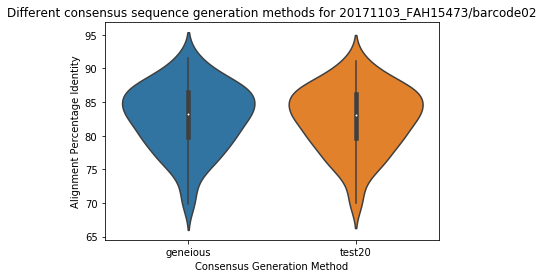

In [6]:
plot = pd.DataFrame(columns=['geneious','test20'])
plot['geneious'] = geneious['alignment identity']
plot['test20'] = test20['alignment identity']

ax = sns.violinplot(data=plot)
ax.set_title("Different consensus sequence generation methods for 20171103_FAH15473/barcode02", fontsize=12)
ax.set_xlabel("Consensus Generation Method", fontsize=10)
ax.set_ylabel("Alignment Percentage Identity", fontsize=10)

plt.show()

In [294]:
%%writefile ../cleanup.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program cleans a consensus sequence by removing any
'n' or 'N' characters
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

with open(args.input_file[:47]+"clean_consensus_1000.fasta","w+") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new)

Overwriting ../cleanup.py


In [83]:
%%writefile ../cleanup_final.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program cleans a consensus sequence by removing any
'n' or 'N' characters
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

with open(args.input_file[:47]+"final_clean_consensus.fasta","w+") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new)

Writing ../cleanup_final.py


In [82]:
%%writefile ../qscore_cleanup.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program cleans a consensus sequence by removing any
'n' or 'N' characters
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

with open(args.input_file[:47]+"clean_qscore_consensus.fasta","w+") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new)

Overwriting ../qscore_cleanup.py


In [295]:
%%writefile ../cleanup_100.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program cleans a consensus sequence by removing any
'n' or 'N' characters
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

with open(args.input_file[:47]+"clean_consensus_100.fasta","w+") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new)

Writing ../cleanup_100.py


In [336]:
%%writefile ../cleanup_101.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program cleans a consensus sequence by removing any
'n' or 'N' characters
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

with open(args.input_file[:47]+"clean_consensus_101.fasta","w+") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new)

Writing ../cleanup_101.py


## Steps to generate consensus

    1. Subsample a set number of reads using the get_cons_ids python script line
    2. From these reads, generate an alignment file using muscle via the create_consensus script line, on the Consensus/ folder
    3. Use the emboss_cons script line to create a consensus from the alignment file, from the analysis folder
        3.5 This also involves a cleanup phase where any 'n' or 'N' character is removed from the resulting file
    4. Collect all cleaned consensus files in a single fasta file using the make_database.sh script
    5. Rename each file???

In [333]:
%%writefile ../make_database_1000.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program writes a cleaned consensus to a database file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')
    
with open("database/custom_database_1000.fasta","a") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new + '\n')

Writing ../make_database_1000.py


In [84]:
%%writefile ../make_database_final.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program writes a cleaned consensus to a database file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.input_file != 'analysis/Consensus/20171207_FAH18654/barcode10/clean_qscore_consensus.fasta' and args.input_file != 'analysis/Consensus/20171212_FAH18688/barcode10/clean_qscore_consensus.fasta':
    if args.verbose:
        print("Input file is " + args.input_file + "\n")
    keys = []
    test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
    for key in test_dict:
        keys.append(key)
    emboss_test = str(test_dict[keys[0]].seq)
    emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

    with open("database/make_database_final.fasta","a") as handle:
        handle.write(">%s\n" % keys[0] + emboss_new + '\n')

Writing ../make_database_final.py


In [227]:
%%writefile ../make_qscore_database.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program writes a cleaned consensus to a database file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.input_file != 'analysis/Consensus/20171207_FAH18654/barcode10/clean_qscore_consensus.fasta' and args.input_file != 'analysis/Consensus/20171212_FAH18688/barcode10/clean_qscore_consensus.fasta':
    if args.verbose:
        print("Input file is " + args.input_file + "\n")
    keys = []
    test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
    for key in test_dict:
        keys.append(key)
    emboss_test = str(test_dict[keys[0]].seq)
    emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')

    with open("database/qscore_database.fasta","a") as handle:
        handle.write(">%s\n" % keys[0] + emboss_new + '\n')

Overwriting ../make_qscore_database.py


In [306]:
%%writefile ../make_database_100.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program writes a cleaned consensus to a database file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')
    
with open("database/custom_database_100.fasta","a") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new + '\n')

Overwriting ../make_database_100.py


In [337]:
%%writefile ../make_database_101.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program writes a cleaned consensus to a database file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

keys = []
test_dict = SeqIO.to_dict(SeqIO.parse(args.input_file,"fasta"))
for key in test_dict:
    keys.append(key)
emboss_test = str(test_dict[keys[0]].seq)
emboss_new = emboss_test.replace('N','').replace('n','').replace('\n','')
    
with open("database/custom_database_101.fasta","a") as handle:
    handle.write(">%s\n" % keys[0] + emboss_new + '\n')

Writing ../make_database_101.py


In [ ]:
%%writefile ../1000_minimap_result.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program extracts a specified number of reads from a fasta
file and saves them to a new fasta file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

f=open(args.input_file,"r")
if f.mode == "r":
    contents=f.read()

tmp=contents.replace("\t",",").split('\n')
tmp_dict = {}
for line in tmp[:-1]:
    tmp_dict[line.split(",")[0]] = str(line.split(",")[5])

count_dict = {}
correct = 0
incorrect = 0
for item in tmp_dict:
    if tmp_dict[item] not in count_dict:
        count_dict[tmp_dict[item]] = 1
    else:
        count_dict[tmp_dict[item]] = count_dict[tmp_dict[item]] + 1
        
tmp = pd.DataFrame.from_dict(count_dict,orient='index',columns=["Count"])
tmp["Percentage Match"] = tmp.apply(lambda row: 100*row.Count/1000,axis=1)
tmp.index.names = ['analysis/Consensus/'+args.input_file[19:-18]]
tmp = tmp.sort_values(by="Count",ascending=False)

if args.verbose:
    print(tmp)

tmp.to_csv(args.input_file[:-18]+'match_distribution.csv',sep=',')

In [270]:
%%writefile ../record_name.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the record.name of entries in a fasta file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

    
with open(args.input_file) as original, open(args.input_file[:-15]+'labelled_read_pool.fasta', 'w') as corrected:
    records = SeqIO.parse(original, 'fasta')
    for record in records:
        record.description = (args.input_file.split('/')[-3]+'_'+args.input_file.split('/')[-2])
        SeqIO.write(record, corrected, 'fasta')

Overwriting ../record_name.py


In [245]:
f=open("../../analysis/Alignment/20171207_FAH18654/barcode12/1000_reads_qiime.paf","r")
if f.mode == "r":
    contents=f.read()  
tmp=contents.replace("\t",",").split('\n')
tmp
tmp_dict = {}
for line in tmp[:-1]:
    tmp_dict[line.split(",")[0]] = str(line.split(",")[5].split('_')[0])
tmp2 = pd.DataFrame.from_dict(data=tmp_dict, orient='index')
counts = tmp2[0].value_counts()
tmp3 = counts.to_frame().reset_index(drop=False)
g=open("../../database/sh_taxonomy_qiime_ver8_dynamic_02.02.2019.txt", "r")
if g.mode == "r":
    contents2=g.read()
tmp4=contents2.replace("\t",",").split("\n")
tmp5 = []
for i in range(0,len(tmp4)):
    tmp5.append(tmp4[i].split(','))

tmp6 = pd.DataFrame(tmp5)
print(tmp3)

tmp_dict2 = {}
for i in range(0,len(tmp6[0])):
    tmp_dict2[tmp6[0][i].split("_")[0]]=tmp6[1][i]

for a,b in tmp3[:7].itertuples(index=False):
    print(a)
    print(b)
    if a in tmp_dict2:
        print(tmp_dict2[a]+'\n')
    else:
        print("not found")

             index    0
0   SH1654757.08FU  436
1   SH1649638.08FU  170
2   SH1560162.08FU  156
3   SH1516182.08FU   48
4   SH1680040.08FU   31
..             ...  ...
59  SH1537723.08FU    1
60  SH1534922.08FU    1
61  SH1554120.08FU    1
62  SH1534396.08FU    1
63  SH1537809.08FU    1

[64 rows x 2 columns]
SH1654757.08FU
436
k__Fungi;p__Ascomycota;c__Orbiliomycetes;o__Orbiliales;f__unidentified;g__unidentified;s__unidentified

SH1649638.08FU
170
k__Fungi;p__Basidiomycota;c__Agaricomycetes;o__Thelephorales;f__Thelephoraceae;g__Tomentella;s__unidentified

SH1560162.08FU
156
k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Microascales;f__Halosphaeriaceae;g__Lignincola;s__Lignincola_laevis

SH1516182.08FU
48
k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Aspergillaceae;g__Chromocleista;s__unidentified

SH1680040.08FU
31
k__Fungi;p__Basidiomycota;c__Agaricomycetes;o__Agaricales;f__Agaricaceae;g__Cystoagaricus;s__Cystoagaricus_hirtosquamulosus

SH1563342.08FU
25
k__Fungi;p__Ascomy

In [219]:
%%writefile ../phylogenetic_naming_qscore.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the title of entries in the consensus fasta
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

true_names = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
             '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
             '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
             '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
             '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
             '20171212_FAH18688/barcode11': 'CCL060',
             '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
             '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

if args.verbose:
    print("Input file is " + args.input_file + "\n")

with open(args.input_file) as original, open(args.input_file[:-21]+'qscore_database_labelled.fasta', 'w+') as labelled:
    for line in original:
        if line.startswith(">"):
            barcode = line.split('/')[2]+'/'+line.split('/')[3]
            species = true_names[barcode]
            newline = '>'+species+'\n'
        else:
            newline = line
        labelled.write(newline)
original.close()
labelled.close()

Writing ../phylogenetic_naming_qscore.py


In [329]:
%%writefile ../phylogenetic_naming_100.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the title of entries in the consensus fasta
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

true_names = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
             '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
             '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
             '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
             '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
             '20171212_FAH18688/barcode11': 'CCL060',
             '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
             '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

if args.verbose:
    print("Input file is " + args.input_file + "\n")

with open(args.input_file) as original, open(args.input_file[:-25]+'custom_database_100_labelled.fasta', 'w+') as labelled:
    for line in original:
        if line.startswith(">"):
            barcode = line.split('/')[2]+'/'+line.split('/')[3]
            species = true_names[barcode]
            newline = '>'+species+'\n'
        else:
            newline = line
        labelled.write(newline)
original.close()
labelled.close()

Overwriting ../phylogenetic_naming_100.py


In [338]:
%%writefile ../phylogenetic_naming_101.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the title of entries in the consensus fasta
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

true_names = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
             '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
             '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
             '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
             '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
             '20171212_FAH18688/barcode11': 'CCL060',
             '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
             '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

if args.verbose:
    print("Input file is " + args.input_file + "\n")

with open(args.input_file) as original, open(args.input_file[:-25]+'custom_database_101_labelled.fasta', 'w+') as labelled:
    for line in original:
        if line.startswith(">"):
            barcode = line.split('/')[2]+'/'+line.split('/')[3]
            species = true_names[barcode]
            newline = '>'+species+'\n'
        else:
            newline = line
        labelled.write(newline)
original.close()
labelled.close()

Writing ../phylogenetic_naming_101.py


In [347]:
%%writefile ../phylogenetic_naming_1000.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the title of entries in the consensus fasta
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

true_names = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
             '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
             '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
             '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
             '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
             '20171212_FAH18688/barcode11': 'CCL060',
             '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
             '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

if args.verbose:
    print("Input file is " + args.input_file + "\n")

with open(args.input_file) as original, open(args.input_file[:-26]+'custom_database_1000_labelled.fasta', 'w+') as labelled:
    for line in original:
        if line.startswith(">"):
            barcode = line.split('/')[2]+'/'+line.split('/')[3]
            species = true_names[barcode]
            newline = '>'+species+'\n'
        else:
            newline = line
        labelled.write(newline)
original.close()
labelled.close()

Overwriting ../phylogenetic_naming_1000.py


In [89]:
%%writefile ../phylogenetic_naming.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the title of entries in the consensus fasta
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

true_names = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
             '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
             '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
             '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
             '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
             '20171212_FAH18688/barcode11': 'CCL060',
             '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
             '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

if args.verbose:
    print("Input file is " + args.input_file + "\n")

with open(args.input_file) as original, open(args.input_file[:-21]+'custom_database_labelled.fasta', 'w+') as labelled:
    for line in original:
        if line.startswith(">"):
            barcode = line.split('/')[2]+'/'+line.split('/')[3]
            species = true_names[barcode]
            newline = '>'+species+'\n'
        else:
            newline = line
        labelled.write(newline)
original.close()
labelled.close()

Overwriting ../phylogenetic_naming.py


In [91]:
%%writefile ../phylogenetic_naming_final.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This program alters the title of entries in the consensus fasta
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

true_names = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
             '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
             '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
             '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
             '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
             '20171212_FAH18688/barcode11': 'CCL060',
             '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
             '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

if args.verbose:
    print("Input file is " + args.input_file + "\n")

with open(args.input_file) as original, open(args.input_file[:-25]+'final_custom_database_labelled.fasta', 'w+') as labelled:
    for line in original:
        if line.startswith(">"):
            barcode = line.split('/')[2]+'/'+line.split('/')[3]
            species = true_names[barcode]
            newline = '>'+species+'\n'
        else:
            newline = line
        labelled.write(newline)
original.close()
labelled.close()

Overwriting ../phylogenetic_naming_final.py


## Steps to generate consensus and tree

    1. Subsample a set number of reads using the get_cons_ids python script line
    2. From these reads, generate an alignment file using muscle via the create_consensus script line, on the Consensus/ folder
    3. Use the emboss_cons script line to create a consensus from the alignment file, from the analysis folder
        3.5 This also involves a cleanup phase where any 'n' or 'N' character is removed from the resulting file
    4. Collect all cleaned consensus files in a single fasta file using the make_database.sh script
    5. Rename each file using the phylogenetic_naming script line
    6. Use muscle to create an alignment file (muscle -in labelled_consensus.fasta -out labelled_consensus.aln)
    7. Download file and export to Geneious
    8. Utilise the Mask Alignment tool to remove gaps
    9. Create tree

In [46]:
phylogeny = {'20171103_FAH15473/barcode01': 'Basidiomycota/Pucciniomycetes/Pucciniales/Pucciniaceae/Puccinia/striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Ascomycota//Dothideomycetes/Capnodiales/Mycosphaerellaceae/Zymoseptoria/tritici',
             '20171103_FAH15473/barcode03': 'Ascomycota/Dothideomycetes/Pleosporales/Pleospraceae/Pyrenophora/tritici-repentis',
             '20171103_FAH15473/barcode04': 'Ascomycota/Sordariomycetes/Hypocreales/Nectriaceae/Fusarium/oxysporum',
             '20171103_FAH15473/barcode05': 'Ascomycota/Pezizomycetes/Pezizales/Tuberaceae/Tuber/brumale',
             '20171103_FAH15473/barcode06': 'Basidiomycota/Agaricales/Cortinariaceae/Cortinarius/globuliformis',
             '20171103_FAH15473/barcode07': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/niger',
             '20171103_FAH15473/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Metschnikowiaceae/Clavispora/lusitaniae',
                 '20171103_FAH15473/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/sp. (Cryptococcus_neoformans)',
             '20171103_FAH15473/barcode10': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Penicillium/chrysogenum',
             '20171103_FAH15473/barcode11': 'Basidiomycota/Microbotryomycetes/Sporidiobolales/Sporidiobolaceae/Rhodotorula/mucilaginosa',
             '20171103_FAH15473/barcode12': 'Ascomycota/Sordariomycetes/Microascales/Microascaceae/Scedosporium/boydii',
             '20171207_FAH18654/barcode01': 'Ascomycota/Saccharomycetes/Saccharomycetales/Trichomonascaceae/Blastobotrys/proliferans',
                 '20171207_FAH18654/barcode02': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Meyerozyma/sp. (Candida_zeylanoides)',
                 '20171207_FAH18654/barcode03': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Galactomyces/geotrichum',
             '20171207_FAH18654/barcode04': 'Ascomycota/Saccharomycetes/Saccharomycetales/Metschnikowiaceae/Kodamaea/ohmeri',
             '20171207_FAH18654/barcode05': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Meyerozyma/guillermondii',
             '20171207_FAH18654/barcode06': 'Ascomycota/Saccharomycetes/Saccharomycetales/Phaffomycetaceae/Wickerhamomyces/anomalus',
             '20171207_FAH18654/barcode07': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Yamadazyma/mexicana',
             '20171207_FAH18654/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Yamadazyma/scolyti',
             '20171207_FAH18654/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Yarrowia/lipolytica',
             '20171207_FAH18654/barcode11': 'Ascomycota/Saccharomycetes/Saccharomycetales/Trichomonascaceae/Zygoascus/hellenicus',
             '20171207_FAH18654/barcode12': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/flavus',
             '20171212_FAH18688/barcode01': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/zero',
             '20171212_FAH18688/barcode02': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/sp.',
                 '20171212_FAH18688/barcode03': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL067',
             '20171212_FAH18688/barcode04': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp.',
             '20171212_FAH18688/barcode05': 'Ascomycota/Leotiomycetes/Helotiales/Dermateaceae/Tapesia/yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Ascomycota/Leotiomycetes/Helotiales/Dermateaceae/Tapesia/yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Ascomycota/Dothideomycetes/Botryosphaeriales/Botryosphaeriaceae/Dothiorella/vidmadera',
             '20171212_FAH18688/barcode08': 'Exobasidiomycetes/Microstromatales/Quambalariaceae/Quambalaria/cyanescens',
             '20171212_FAH18688/barcode09': 'Ascomycota/Sordariomycetes/Xylariales.Xylariaceae/Entoleuca/sp.',
                 '20171212_FAH18688/barcode11': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL060',
                 '20171212_FAH18688/barcode12': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL068',
             '20180108_FAH18647/barcode01': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Saccharomyces/cerevisiae',
             '20180108_FAH18647/barcode02': 'Ascomycota/Eurotiomycetes/Chaetothyriales/Herpotrichiellaceae/Cladophialophora/sp.',
             '20180108_FAH18647/barcode03': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/albicans',
             '20180108_FAH18647/barcode04': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/metapsilosis',
             '20180108_FAH18647/barcode05': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/orthopsilosis',
             '20180108_FAH18647/barcode06': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/parapsilosis',
                 '20180108_FAH18647/barcode07': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/sp. (Cryptococcus_gattii)',
             '20180108_FAH18647/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Geotrichum/candidum',
             '20180108_FAH18647/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/lactis',
             '20180108_FAH18647/barcode10': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/marxianus',
             '20180108_FAH18647/barcode11': 'Ascomycota/Saccharomycetes/Saccharomycetales/Pichiaceae/Pichia/kudriavzevii',
             '20180108_FAH18647/barcode12': 'Ascomycota/Saccharomycetes/Saccharomycetales/Pichiaceae/Pichia/membranifaciens'}

In [265]:
%%writefile ../test_reads_vs_database.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse

parser = argparse.ArgumentParser(description="""
Enter the analysis directory to generate a dataframe that extracts the details
for each sample
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

phylogeny = {'20171103_FAH15473/barcode01': 'Basidiomycota/Pucciniomycetes/Pucciniales/Pucciniaceae/Puccinia/striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Ascomycota/Dothideomycetes/Capnodiales/Mycosphaerellaceae/Zymoseptoria/tritici',
             '20171103_FAH15473/barcode03': 'Ascomycota/Dothideomycetes/Pleosporales/Pleospraceae/Pyrenophora/tritici-repentis',
             '20171103_FAH15473/barcode04': 'Ascomycota/Sordariomycetes/Hypocreales/Nectriaceae/Fusarium/oxysporum',
             '20171103_FAH15473/barcode05': 'Ascomycota/Pezizomycetes/Pezizales/Tuberaceae/Tuber/brumale',
             '20171103_FAH15473/barcode06': 'Basidiomycota/Agaricomycetes/Agaricales/Cortinariaceae/Cortinarius/globuliformis',
             '20171103_FAH15473/barcode07': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/niger',
             '20171103_FAH15473/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Metschnikowiaceae/Clavispora/lusitaniae',
                 '20171103_FAH15473/barcode09': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/neoformans',
             '20171103_FAH15473/barcode10': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Penicillium/chrysogenum',
             '20171103_FAH15473/barcode11': 'Basidiomycota/Microbotryomycetes/Sporidiobolales/Sporidiobolaceae/Rhodotorula/mucilaginosa',
             '20171103_FAH15473/barcode12': 'Ascomycota/Sordariomycetes/Microascales/Microascaceae/Scedosporium/boydii',
             '20171207_FAH18654/barcode01': 'Ascomycota/Saccharomycetes/Saccharomycetales/Trichomonascaceae/Blastobotrys/proliferans',
                 '20171207_FAH18654/barcode02': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/zeylanoides',
                 '20171207_FAH18654/barcode03': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Galactomyces/geotrichum',
             '20171207_FAH18654/barcode04': 'Ascomycota/Saccharomycetes/Saccharomycetales/Metschnikowiaceae/Kodamaea/ohmeri',
             '20171207_FAH18654/barcode05': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Meyerozyma/guillermondii',
             '20171207_FAH18654/barcode06': 'Ascomycota/Saccharomycetes/Saccharomycetales/Phaffomycetaceae/Wickerhamomyces/anomalus',
             '20171207_FAH18654/barcode07': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Yamadazyma/mexicana',
             '20171207_FAH18654/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Yamadazyma/scolyti',
             '20171207_FAH18654/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Yarrowia/lipolytica',
             '20171207_FAH18654/barcode11': 'Ascomycota/Saccharomycetes/Saccharomycetales/Trichomonascaceae/Zygoascus/hellenicus',
             '20171207_FAH18654/barcode12': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/flavus',
             '20171212_FAH18688/barcode01': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/zero',
             '20171212_FAH18688/barcode02': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/sp.',
                 '20171212_FAH18688/barcode03': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL067',
             '20171212_FAH18688/barcode04': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp.',
             '20171212_FAH18688/barcode05': 'Ascomycota/Leotiomycetes/Helotiales/Dermateaceae/Oculimacula/yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Ascomycota/Leotiomycetes/Helotiales/Dermateaceae/Oculimacula/yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Ascomycota/Dothideomycetes/Botryosphaeriales/Botryosphaeriaceae/Dothiorella/vidmadera',
             '20171212_FAH18688/barcode08': 'Exobasidiomycetes/Microstromatales/Quambalariaceae/Quambalaria/cyanescens',
             '20171212_FAH18688/barcode09': 'Ascomycota/Sordariomycetes/Xylariales.Xylariaceae/Entoleuca/sp.',
                 '20171212_FAH18688/barcode11': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL060',
                 '20171212_FAH18688/barcode12': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL068',
             '20180108_FAH18647/barcode01': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Saccharomyces/cerevisiae',
             '20180108_FAH18647/barcode02': 'Ascomycota/Eurotiomycetes/Chaetothyriales/Herpotrichiellaceae/Cladophialophora/sp.',
             '20180108_FAH18647/barcode03': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/albicans',
             '20180108_FAH18647/barcode04': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/metapsilosis',
             '20180108_FAH18647/barcode05': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/orthopsilosis',
             '20180108_FAH18647/barcode06': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/parapsilosis',
                 '20180108_FAH18647/barcode07': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/gattii',
             '20180108_FAH18647/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Geotrichum/candidum',
             '20180108_FAH18647/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/lactis',
             '20180108_FAH18647/barcode10': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/marxianus',
             '20180108_FAH18647/barcode11': 'Ascomycota/Saccharomycetes/Saccharomycetales/Pichiaceae/Pichia/kudriavzevii',
             '20180108_FAH18647/barcode12': 'Ascomycota/Saccharomycetes/Saccharomycetales/Pichiaceae/Pichia/membranifaciens'}
input_file = args.input_file

print(input_file+'\n')

f=open(input_file,"r")
if f.mode == "r":
    contents=f.read()  
tmp=contents.replace("\t",",").split('\n')
tmp
tmp_dict = {}
counter=0

for line in tmp[:-1]:
    tmp_dict[counter] = str(line.split(",")[5].split('_')[0])
    counter+=1
tmp2 = pd.DataFrame.from_dict(data=tmp_dict, orient='index')
counts = tmp2[0].value_counts()
tmp3 = counts.to_frame().reset_index(drop=False)

g=open("database/sh_taxonomy_qiime_ver8_dynamic_02.02.2019.txt", "r")
if g.mode == "r":
    contents2=g.read()
tmp4=contents2.replace("\t",",").split("\n")

tmp5 = []
for i in range(0,len(tmp4)):
    tmp5.append(tmp4[i].split(','))

tmp6 = pd.DataFrame(tmp5)

tmp_dict2 = {}
for i in range(0,len(tmp6[0])):
    tmp_dict2[tmp6[0][i].split("_")[0]]=tmp6[1][i]

    
tobewritten = pd.DataFrame(data=[],columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'])

for a,b in tmp3[:7].itertuples(index=False):
    # a == id, b == count
    if a in tmp_dict2:
        tmp_specs = []
        tmp_specs.append(b)
        if len(tmp_dict2[a].split('s__')[-1].split('_')) > 1:
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[1])
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[0])
        else:
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[0])
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-1].split(';')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-2].split('o__')[-1].split(';')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-2].split('o__')[-2].split('c__')[-1].split(';')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-2].split('o__')[-2].split('c__')[-2].split('p__')[-1].split(';')[0])
        tmpf = pd.DataFrame([tmp_specs],columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=[a])
        tobewritten = tobewritten.append(tmpf)

correct_list = ['N/A', phylogeny[input_file[19:-19]].split('/')[-1].split('_')[0], phylogeny[input_file[19:-19]].split('/')[-2],phylogeny[input_file[19:-19]].split('/')[-3],phylogeny[input_file[19:-19]].split('/')[-4],phylogeny[input_file[19:-19]].split('/')[-5],phylogeny[input_file[19:-19]].split('/')[-6]]
correct = pd.DataFrame([correct_list], columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=['Suggested'])
tobewritten = tobewritten.append(correct)

consensus = [0]*7
count = 0
for line in tobewritten:
    if line != 'Count':
        tmps = tobewritten[line].value_counts().to_frame()
        consensus[count] = tmps.index[0]
        count += 1
    else:
        consensus[count] = 'N/A'
        count += 1
consensus = pd.DataFrame([consensus], columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=['Consensus Match'])
tobewritten = tobewritten.append([consensus])

if (correct.values[0][1:2] == consensus.values[0][1:2]).all():
    print('\033[0;31m'+"SPECIES MATCH"+'\033[1;37m')
else:
    print('\033[0;34m'+"NO SPECIES MATCH"+'\033[1;37m')
    
if (correct.values[0][2:3] == consensus.values[0][2:3]).all():
    print('\033[0;31m'+"GENUS MATCH"+'\033[1;37m')
else:
    print('\033[0;34m'+"NO GENUS MATCH"+'\033[1;37m')
    
if (correct.values[0][3:4] == consensus.values[0][3:4]).all():
    print('\033[0;31m'+"FAMILY MATCH"+'\033[1;37m')
else:
    print('\033[0;34m'+"NO FAMILY MATCH"+'\033[1;37m')
    
if (correct.values[0][4:5] == consensus.values[0][4:5]).all():
    print('\033[0;31m'+"ORDER MATCH"+'\033[1;37m')
else:
    print('\033[0;34m'+"NO ORDER MATCH"+'\033[1;37m')
    
if (correct.values[0][5:6] == consensus.values[0][5:6]).all():
    print('\033[0;31m'+"CLASS MATCH"+'\033[1;37m')
else:
    print('\033[0;34m'+"NO CLASS MATCH"+'\033[1;37m')
    
if (correct.values[0][6:] == consensus.values[0][6:]).all():
    print('\033[0;31m'+"PHYLUM MATCH"+'\033[1;37m')
else:
    print('\033[0;34m'+"NO PHYLUM MATCH"+'\033[1;37m')
    
print('\n\n')


tobewritten.to_csv(input_file[:-18]+'reads_matches_found.csv')

Overwriting ../test_reads_vs_database.py


In [14]:
%%writefile ../test_consensus_vs_database.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse

parser = argparse.ArgumentParser(description="""
Enter the analysis directory to generate a dataframe that extracts the details
for each sample
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

phylogeny = {'20171103_FAH15473/barcode01': 'Basidiomycota/Pucciniomycetes/Pucciniales/Pucciniaceae/Puccinia/striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Ascomycota/Dothideomycetes/Capnodiales/Mycosphaerellaceae/Zymoseptoria/tritici',
             '20171103_FAH15473/barcode03': 'Ascomycota/Dothideomycetes/Pleosporales/Pleospraceae/Pyrenophora/tritici-repentis',
             '20171103_FAH15473/barcode04': 'Ascomycota/Sordariomycetes/Hypocreales/Nectriaceae/Fusarium/oxysporum',
             '20171103_FAH15473/barcode05': 'Ascomycota/Pezizomycetes/Pezizales/Tuberaceae/Tuber/brumale',
             '20171103_FAH15473/barcode06': 'Basidiomycota/Agaricomycetes/Agaricales/Cortinariaceae/Cortinarius/globuliformis',
             '20171103_FAH15473/barcode07': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/niger',
             '20171103_FAH15473/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Metschnikowiaceae/Clavispora/lusitaniae',
                 '20171103_FAH15473/barcode09': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/neoformans',
             '20171103_FAH15473/barcode10': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Penicillium/chrysogenum',
             '20171103_FAH15473/barcode11': 'Basidiomycota/Microbotryomycetes/Sporidiobolales/Sporidiobolaceae/Rhodotorula/mucilaginosa',
             '20171103_FAH15473/barcode12': 'Ascomycota/Sordariomycetes/Microascales/Microascaceae/Scedosporium/boydii',
             '20171207_FAH18654/barcode01': 'Ascomycota/Saccharomycetes/Saccharomycetales/Trichomonascaceae/Blastobotrys/proliferans',
                 '20171207_FAH18654/barcode02': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/zeylanoides',
                 '20171207_FAH18654/barcode03': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Galactomyces/geotrichum',
             '20171207_FAH18654/barcode04': 'Ascomycota/Saccharomycetes/Saccharomycetales/Metschnikowiaceae/Kodamaea/ohmeri',
             '20171207_FAH18654/barcode05': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Meyerozyma/guillermondii',
             '20171207_FAH18654/barcode06': 'Ascomycota/Saccharomycetes/Saccharomycetales/Phaffomycetaceae/Wickerhamomyces/anomalus',
             '20171207_FAH18654/barcode07': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Yamadazyma/mexicana',
             '20171207_FAH18654/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Debaryomycetaceae/Yamadazyma/scolyti',
             '20171207_FAH18654/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Yarrowia/lipolytica',
             '20171207_FAH18654/barcode11': 'Ascomycota/Saccharomycetes/Saccharomycetales/Trichomonascaceae/Zygoascus/hellenicus',
             '20171207_FAH18654/barcode12': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/flavus',
             '20171212_FAH18688/barcode01': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/zero',
             '20171212_FAH18688/barcode02': 'Ascomycota/Eurotiomycetes/Eurotiales/Trichocomaceae/Aspergillus/sp.',
                 '20171212_FAH18688/barcode03': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL067',
             '20171212_FAH18688/barcode04': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp.',
             '20171212_FAH18688/barcode05': 'Ascomycota/Leotiomycetes/Helotiales/Dermateaceae/Oculimacula/yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Ascomycota/Leotiomycetes/Helotiales/Dermateaceae/Oculimacula/yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Ascomycota/Dothideomycetes/Botryosphaeriales/Botryosphaeriaceae/Dothiorella/vidmadera',
             '20171212_FAH18688/barcode08': 'Exobasidiomycetes/Microstromatales/Quambalariaceae/Quambalaria/cyanescens',
             '20171212_FAH18688/barcode09': 'Ascomycota/Sordariomycetes/Xylariales.Xylariaceae/Entoleuca/sp.',
                 '20171212_FAH18688/barcode11': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL060',
                 '20171212_FAH18688/barcode12': 'Ascomycota/Sordariomycetes/Diaporthales/Diaporthaceae/Diaporthe/sp._CCL068',
             '20180108_FAH18647/barcode01': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Saccharomyces/cerevisiae',
             '20180108_FAH18647/barcode02': 'Ascomycota/Eurotiomycetes/Chaetothyriales/Herpotrichiellaceae/Cladophialophora/sp.',
             '20180108_FAH18647/barcode03': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/albicans',
             '20180108_FAH18647/barcode04': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/metapsilosis',
             '20180108_FAH18647/barcode05': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/orthopsilosis',
             '20180108_FAH18647/barcode06': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Candida/parapsilosis',
                 '20180108_FAH18647/barcode07': 'Basidiomycota/Tremellomycetes/Tremellales/Tremellaceae/Cryptococcus/gattii',
             '20180108_FAH18647/barcode08': 'Ascomycota/Saccharomycetes/Saccharomycetales/Dipodascaceae/Geotrichum/candidum',
             '20180108_FAH18647/barcode09': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/lactis',
             '20180108_FAH18647/barcode10': 'Ascomycota/Saccharomycetes/Saccharomycetales/Saccharomycetaceae/Kluyveromyces/marxianus',
             '20180108_FAH18647/barcode11': 'Ascomycota/Saccharomycetes/Saccharomycetales/Pichiaceae/Pichia/kudriavzevii',
             '20180108_FAH18647/barcode12': 'Ascomycota/Saccharomycetes/Saccharomycetales/Pichiaceae/Pichia/membranifaciens'}
input_file = args.input_file

print(input_file+'\n')

f=open(input_file,"r")
if f.mode == "r":
    contents=f.read()  
tmp=contents.replace("\t",",").split('\n')
tmp
tmp_dict = {}
counter=0

for line in tmp[:-1]:
    tmp_dict[counter] = str(line.split(",")[5].split('_')[0])
    counter+=1
tmp2 = pd.DataFrame.from_dict(data=tmp_dict, orient='index')
counts = tmp2[0].value_counts()
tmp3 = counts.to_frame().reset_index(drop=False)

g=open("database/sh_taxonomy_qiime_ver8_dynamic_02.02.2019.txt", "r")
if g.mode == "r":
    contents2=g.read()
tmp4=contents2.replace("\t",",").split("\n")

tmp5 = []
for i in range(0,len(tmp4)):
    tmp5.append(tmp4[i].split(','))

tmp6 = pd.DataFrame(tmp5)

tmp_dict2 = {}
for i in range(0,len(tmp6[0])):
    tmp_dict2[tmp6[0][i].split("_")[0]]=tmp6[1][i]

    
tobewritten = pd.DataFrame(data=[],columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'])

for a,b in tmp3[:7].itertuples(index=False):
    # a == id, b == count
    if a in tmp_dict2:
        tmp_specs = []
        tmp_specs.append(b)
        if len(tmp_dict2[a].split('s__')[-1].split('_')) > 1:
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[1])
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[0])
        else:
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[0])
            tmp_specs.append(tmp_dict2[a].split('s__')[-1].split('_')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-1].split(';')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-2].split('o__')[-1].split(';')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-2].split('o__')[-2].split('c__')[-1].split(';')[0])
        tmp_specs.append(tmp_dict2[a].split('s__')[-2].split('g__')[-2].split('f__')[-2].split('o__')[-2].split('c__')[-2].split('p__')[-1].split(';')[0])
        tmpf = pd.DataFrame([tmp_specs],columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=[a])
        tobewritten = tobewritten.append(tmpf)

        
pd.set_option('display.max_rows', None)
print('\033[0;34m')
print(tobewritten)
print('\033[1;37m')       
# correct_list = ['N/A', phylogeny[input_file[19:-33]].split('/')[-1].split('_')[0], phylogeny[input_file[19:-33]].split('/')[-2],phylogeny[input_file[19:-33]].split('/')[-3],phylogeny[input_file[19:-33]].split('/')[-4],phylogeny[input_file[19:-33]].split('/')[-5],phylogeny[input_file[19:-33]].split('/')[-6]]
# correct = pd.DataFrame([correct_list], columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=['Suggested'])

# tps1 = correct[['Species Match']]
# tps2 = tobewritten[['Species Match']]
# tpg1 = correct[['Genus Match']]
# tpg2 = tobewritten[['Genus Match']]
# print(pd.merge(tps1,tps2,on='Species Match'))
# if pd.merge(tps1,tps2,on='Species Match').any().any():
#     print('\033[0;34m')
#     print(pd.merge(tps1,tps2,on='Species Match').any())
# else:
#     print('\033[0;31m')
#     print(pd.merge(tps1,tps2,on='Species Match').any())
# print('\033[1;37m')

# print(pd.merge(tpg1,tpg2,on='Genus Match'))
# if pd.merge(tpg1,tpg2,on='Genus Match').any().any():
#     print('\033[0;34m')
#     print(pd.merge(tpg1,tpg2,on='Genus Match').any())
# else:
#     print('\033[0;31m')
#     print(pd.merge(tpg1,tpg2,on='Genus Match').any())
# print('\033[1;37m')



# consensus = [0]*7
# count = 0
# total = 0
# match = 0
# for line in tobewritten:
#     if line != 'Count':
#         tmps = tobewritten[line].value_counts().to_frame()
#         if tmps.index[0] in correct_list:
#             consensus[count] = tmps.index[0]
#             print(consensus[count])
#         else:
#             print("NO")
#         count += 1
#     else:
#         consensus[count] = 'N/A'
#         count += 1

        
# correct = pd.DataFrame([correct_list], columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=['Suggested'])
# tobewritten = tobewritten.append(correct)

# consensus = pd.DataFrame([consensus], columns=['Count','Species Match','Genus Match','Family Match','Order Match','Class Match','Phylum Match'],index=['Consensus Match'])
# tobewritten = tobewritten.append([consensus])

# if (correct.values[0][1:2] == consensus.values[0][1:2]).all():
#     print('\033[0;31m'+"SPECIES MATCH"+'\033[1;37m')
# else:
#     print('\033[0;34m'+"NO SPECIES MATCH"+'\033[1;37m')
    
# if (correct.values[0][2:3] == consensus.values[0][2:3]).all():
#     print('\033[0;31m'+"GENUS MATCH"+'\033[1;37m')
# else:
#     print('\033[0;34m'+"NO GENUS MATCH"+'\033[1;37m')
    
# if (correct.values[0][3:4] == consensus.values[0][3:4]).all():
#     print('\033[0;31m'+"FAMILY MATCH"+'\033[1;37m')
# else:
#     print('\033[0;34m'+"NO FAMILY MATCH"+'\033[1;37m')
    
# if (correct.values[0][4:5] == consensus.values[0][4:5]).all():
#     print('\033[0;31m'+"ORDER MATCH"+'\033[1;37m')
# else:
#     print('\033[0;34m'+"NO ORDER MATCH"+'\033[1;37m')
    
# if (correct.values[0][5:6] == consensus.values[0][5:6]).all():
#     print('\033[0;31m'+"CLASS MATCH"+'\033[1;37m')
# else:
#     print('\033[0;34m'+"NO CLASS MATCH"+'\033[1;37m')
    
# if (correct.values[0][6:] == consensus.values[0][6:]).all():
#     print('\033[0;31m'+"PHYLUM MATCH"+'\033[1;37m')
# else:
#     print('\033[0;34m'+"NO PHYLUM MATCH"+'\033[1;37m')
    
# print('\n\n')


# tobewritten.to_csv(input_file[:-32]+'matches_found.csv')

Overwriting ../test_consensus_vs_database.py


In [36]:
%%writefile ../overall_statistics.py

"""
The goal of this program is to examine the distribution of reads within
each file, and for the files generated after homology analysis.
The program will generate summary statistics for the result of the homology
analysis and save figures illustrating the read distribution for the
frDNA reads
"""

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import csv


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
The goal of this program is to examine the distribution of reads within
each file, and for the files generated after homology analysis.
The program will generate summary statistics for the result of the homology
analysis and save figures illustrating the read distribution for the
frDNA reads
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("full_file")
args = parser.parse_args()
print('\033[0;35m'+'START'+'\033[1;37m')
full_file = args.full_file
print(full_file)
homology_folder = args.full_file[:9]+'Python_Processing'+args.full_file[21:-12]+'combined_test.paf'
print(homology_folder)
length_folder = args.full_file[:9]+'Length_Filtered'+args.full_file[21:-12]+'length_restricted_reads.fasta'
print(length_folder)

# Load the full file containing all reads for this barcode
full_file_dict = SeqIO.to_dict(SeqIO.parse(full_file, "fastq"))

if args.verbose:
    print('\033[0;34m' + "Loaded " + full_file + '\033[1;37m')

    
# Open the original merged.fastq file
# Extract the number of reads contained within this file
full_lengths = []
for key in full_file_dict:
    full_lengths.append(len(full_file_dict[key].seq))
full_lengths_len = len(full_file_dict)
print(full_lengths_len)


# Import the PAF file resulting from the minimap2 homology filtering
homology_paf = pd.read_csv(homology_folder, sep='\t', header=None, engine='python')

if args.verbose:
    print('\033[0;34m' + "Loaded " + homology_folder + '\033[1;37m')
          
# Create new dictionary using only keys present in paf file
# Extract the number of reads contained within this file
homology_dict = {}
for key in homology_paf[0].unique():
    homology_dict[key] = full_file_dict[key]

homology_lengths = []
for key in homology_dict:
          homology_lengths.append(len(homology_dict[key].seq))
homology_lengths_len = len(homology_lengths)
print(homology_lengths_len)

if args.verbose:
    print('\033[0;34m' + "Loaded " + length_folder + '\033[1;37m')
    
# Open length restricted fasta
# Extract the number of reads contained within this file
length_dict = SeqIO.to_dict(SeqIO.parse(length_folder, "fasta"))

length_lengths = []
for key in length_dict:
    length_lengths.append(len(length_dict[key].seq))
length_lengths_len = len(length_dict)
print(length_lengths_len)

number_of_reads = pd.DataFrame([[full_lengths_len, homology_lengths_len, length_lengths_len]], columns=['Original # reads','# reads after homology filtering','# reads after length filtering'])
number_of_reads.to_csv(args.full_file[:9]+'Stats'+args.full_file[21:-12]+'read_numbers.csv', index=False)

if args.verbose:
    print('\033[0;32m' + "Number of reads file saved to " + args.full_file[:9]+'Stats'+args.full_file[21:-12]+'read_numbers.csv' + '\033[1;37m')

fields = [full_lengths_len, homology_lengths_len, length_lengths_len]
if args.full_file[40:-13] != 'unclassified':
    if '20171212_FAH18688/barcode10' not in args.full_file[22:-13] and '20171207_FAH18654/barcode10' not in args.full_file[22:-13]:
        with open(args.full_file[:9]+'Stats/read_numbers.csv','a+') as fd:
            writer = csv.writer(fd)
            writer.writerow(fields)
print('\033[0;35m'+'END'+'\033[1;37m')

Overwriting ../overall_statistics.py


In [30]:
number_stats = pd.read_csv('../../analysis/Stats/read_number.csv', header=None, engine='python')
print(number_stats)
print(np.mean(number_stats[0]))
print(np.mean(number_stats[1]))
print(min(number_stats[2]))
print(max(number_stats[2]))
print(np.mean(number_stats[2]))

         0       1       2
0   272465  122080  113337
1   413127  143363  133089
2   260896   97584   90015
3   382450  131411  123742
4   275035   80614   74232
5   347423  128993  117090
6   171615   65065   59406
7   352768  141856  131936
8   370154  165113  152736
9   192173   78105   72307
10  318405  127801  117801
11  331947  102481   93723
12  133835   39631   37315
13  174974   35837   33499
14  152933    8485    7805
15  111257   38931   36478
16  211853   20333   18944
17  193187   45720   42589
18  179240   45093   42369
19  136650   37159   34841
20  141238   35950   33873
21  229073   36666   34002
22  125014   54061   51340
23  167818   42373   39235
24  249468   42899   39988
25  172601   32847   30504
26  198500   29833   27941
27  213143   52944   49481
28  223186   59651   55589
29  204777   47318   44257
30  205404   49780   46171
31  155158   33941   31356
32  206161   42329   39836
33  188353   33438   31996
34   96837   33025   30260
35  115477   28063   25917
3

In [ ]:
for i in range(0,len(tmp['read_id'][1:])):
    tmps = pd.DataFrame(data=[tmp['read_id'][i+1:],tmp['mean_qscore_template'][i+1:]])
    id_scores.append(tmps)

In [33]:
tmp = pd.read_csv("../../analysis/Basecalled/20171103_FAH15473/barcode01/sequencing_summary.txt",sep='\t', header=None, names=['filename', 'read_id', 'run_id', 'batch_id', 'channel', 'mux', 'start_time', 'duration', 'num_events', 'passes_filtering', 'template_start', 'num_events_template', 'template_duration', 'sequence_length_template', 'mean_qscore_template', 'strand_score_template', 'median_template', 'mad_template'], engine='python')
tmpd = SeqIO.to_dict(SeqIO.parse("../../analysis/Length_Filtered/20171103_FAH15473/barcode01/length_restricted_reads.fasta", "fasta"))
keys = []
for key in tmpd:
    keys.append(key)
id_score = pd.DataFrame(data=None,columns=['read_id','mean_qscore_template'])
tmp_keys = {}
for i in range(1,len(tmp)):
    tmp_keys[tmp['read_id'][i]] = tmp['mean_qscore_template'][i]
for key in keys:
    if key in tmp_keys:
        tmpf = pd.DataFrame(data=[[key,tmp_keys[key]]],columns=['read_id','mean_qscore_template'])
    id_score = id_score.append(tmpf)
id_score = id_score.sort_values(by=['mean_qscore_template'])
new_ids_list = id_score['read_id'][:100]

new_dict = {}
for key in new_ids_list:
    new_dict[key] = tmpd[key]
SeqIO.write(new_dict.values(), "../../analysis/Consensus/20171103_FAH15473/barcode01/high_qscore_100.fasta", "fasta")

100

In [43]:
%%writefile ../for_consensus_high_qscore_100.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from mothur_py import Mothur
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


WHITE='\033[1;37m'
BLUE='\033[0;34m'
RED='\033[0;31m'
NC='\033[0m'
GREEN='\033[0;32m'
PURPLE='\033[1;35m'

parser = argparse.ArgumentParser(description="""
Input the sequencing_summary.txt file from Basecalled
Read in the length_restricted_reads.fasta from Length_Filtered
Save to Consensus
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print('\033[0;31m' + "Input file is " + args.input_file + '\033[1;37m')

    
tmp = pd.read_csv(args.input_file,sep='\t', header=None, names=['filename', 'read_id', 'run_id', 'batch_id', 'channel', 'mux', 'start_time', 'duration', 'num_events', 'passes_filtering', 'template_start', 'num_events_template', 'template_duration', 'sequence_length_template', 'mean_qscore_template', 'strand_score_template', 'median_template', 'mad_template'], engine='python')
tmpd = SeqIO.to_dict(SeqIO.parse("Length_Filtered"+args.input_file[10:-22]+"length_restricted_reads.fasta", "fasta"))
keys = []
for key in tmpd:
    keys.append(key)
id_score = pd.DataFrame(data=None,columns=['read_id','mean_qscore_template'])
tmp_keys = {}
for i in range(1,len(tmp)):
    tmp_keys[tmp['read_id'][i]] = tmp['mean_qscore_template'][i]
for key in keys:
    if key in tmp_keys:
        tmpf = pd.DataFrame(data=[[key,tmp_keys[key]]],columns=['read_id','mean_qscore_template'])
    id_score = id_score.append(tmpf)
id_score = id_score.sort_values(by=['mean_qscore_template'])
new_ids_list = id_score['read_id'][:100]

new_dict = {}
for key in new_ids_list:
    new_dict[key] = tmpd[key]
SeqIO.write(new_dict.values(), "Consensus"+args.input_file[10:-22]+"high_qscore_100.fasta", "fasta")
    

if args.verbose:
    print('\033[0;34m' + "Reads saved to " + '\033[0;35m' + "Consensus"+args.input_file[10:-22]+"high_qscore_100.fasta" + '\033[1;37m')

Overwriting ../for_consensus_high_qscore_100.py


### Map genetic distance on x vs crossmapping percentage on y

In [4]:
phylogeny = {'20171103_FAH15473/barcode01': 'Puccinia_striiformis_tritici',
             '20171103_FAH15473/barcode02': 'Zymoseptoria_tritici',
             '20171103_FAH15473/barcode03': 'Pyrenophora_tritici-repentis',
             '20171103_FAH15473/barcode04': 'Fusarium_oxysporum',
             '20171103_FAH15473/barcode05': 'Tuber_brumale',
             '20171103_FAH15473/barcode06': 'Cortinarius_globuliformis',
             '20171103_FAH15473/barcode07': 'Aspergillus_niger',
             '20171103_FAH15473/barcode08': 'Clavispora_lusitaniae',
                 '20171103_FAH15473/barcode09': 'Cryptococcus_neoformans',
             '20171103_FAH15473/barcode10': 'Penicillium_chrysogenum',
             '20171103_FAH15473/barcode11': 'Rhodotorula_mucilaginosa',
             '20171103_FAH15473/barcode12': 'Scedosporium_boydii',
             '20171207_FAH18654/barcode01': 'Blastobotrys_proliferans',
                 '20171207_FAH18654/barcode02': 'Candida_zeylanoides',
                 '20171207_FAH18654/barcode03': 'Galactomyces_geotrichum',
             '20171207_FAH18654/barcode04': 'Kodamaea_ohmeri',
             '20171207_FAH18654/barcode05': 'Meyerozyma_guillermondii',
             '20171207_FAH18654/barcode06': 'Wickerhamomyces_anomalus',
             '20171207_FAH18654/barcode07': 'Yamadazyma_mexicana',
             '20171207_FAH18654/barcode08': 'Yamadazyma_scolyti',
             '20171207_FAH18654/barcode09': 'Yarrowia_lipolytica',
             '20171207_FAH18654/barcode11': 'Zygoascus_hellenicus',
             '20171207_FAH18654/barcode12': 'Aspergillus_flavus',
             '20171212_FAH18688/barcode01': 'Cryptococcus_zero',
             '20171212_FAH18688/barcode02': 'Aspergillus_sp.',
                 '20171212_FAH18688/barcode03': 'CCL067',
             '20171212_FAH18688/barcode04': 'Diaporthe_sp.',
             '20171212_FAH18688/barcode05': 'Tapesia_yallundae_CCL031',
             '20171212_FAH18688/barcode06': 'Tapesia_yallundae_CCL029',
             '20171212_FAH18688/barcode07': 'Dothiorella_vidmadera',
             '20171212_FAH18688/barcode08': 'Quambalaria_cyanescens',
             '20171212_FAH18688/barcode09': 'Entoleuca_sp.',
                 '20171212_FAH18688/barcode11': 'CCL060',
                 '20171212_FAH18688/barcode12': 'CCL068',
             '20180108_FAH18647/barcode01': 'Saccharomyces_cerevisiae',
             '20180108_FAH18647/barcode02': 'Cladophialophora_sp.',
             '20180108_FAH18647/barcode03': 'Candida_albicans',
             '20180108_FAH18647/barcode04': 'Candida_metapsilosis',
             '20180108_FAH18647/barcode05': 'Candida_orthopsilosis',
             '20180108_FAH18647/barcode06': 'Candida_parapsilosis',
                 '20180108_FAH18647/barcode07': 'Cryptococcus_gattii',
             '20180108_FAH18647/barcode08': 'Geotrichum_candidum',
             '20180108_FAH18647/barcode09': 'Kluyveromyces_lactis',
             '20180108_FAH18647/barcode10': 'Kluyveromyces_marxianus',
             '20180108_FAH18647/barcode11': 'Pichia_kudriavzevii',
             '20180108_FAH18647/barcode12': 'Pichia_membranifaciens'}

large_frame = pd.read_csv("../../analysis/Alignment/database.csv", header=0, index_col=0, engine='python')

In [5]:
large_frame

Puccinia_striiformis_tritici  \
Puccinia_striiformis_tritici                           NaN   
Geotrichum_candidum                                 63.080   
Rhodotorula_mucilaginosa                            79.119   
Cortinarius_globuliformis                           77.724   
Cryptococcus_zero                                   78.490   
Quambalaria_cyanescens                              78.029   
Yarrowia_lipolytica                                 67.484   
Tuber_brumale                                       74.459   
Diaporthe_sp.                                       72.815   
CCL060                                              72.503   
CCL067                                              72.908   
CCL068                                              72.544   
Scedosporium_boydii                                 70.945   
Fusarium_oxysporum                                  72.677   
Entoleuca_sp.                                       72.500   
Pyrenophora_tritici-repentis                        73.861   
Cladophialophora_sp.                                73.411   
Penicillium_chrysogenum                             72.631   
Aspergillus_flavus                                  72.332   
Aspergillus_niger                                   72.005   
Aspergillus_sp.                                     71.844   
Tapesia_yallundae_CCL031                            74.141   
Tapesia_yallundae_CCL029                            73.956   
Zymoseptoria_tritici                                73.702   
Dothiorella_vidmadera                               74.615   
Pichia_kudriavzevii                                 70.411   
Pichia_membranifaciens                              70.372   
Galactomyces_geotrichum                             71.641   
Zygoascus_hellenicus                                75.627   
Clavispora_lusitaniae                               70.284   
Blastobotrys_proliferans                            77.021   
Cryptococcus_neoformans                             74.691   
Kluyveromyces_marxianus                             74.297   
Saccharomyces_cerevisiae                            75.683   
Kodamaea_ohmeri                                     71.033   
Wickerhamomyces_anomalus                            74.180   
Candida_albicans                                    74.129   
Kluyveromyces_lactis                                74.597   
Cryptococcus_gattii                                 72.674   
Candida_parapsilosis                                75.689   
Candida_metapsilosis                                75.569   
Candida_orthopsilosis                               75.603   
Yamadazyma_mexicana                                 74.991   
Yamadazyma_scolyti                                  74.607   
Candida_zeylanoides                                 76.313   
Meyerozyma_guillermondii                            75.231   

                              Geotrichum_candidum  Rhodotorula_mucilaginosa  \
Puccinia_striiformis_tritici               63.080                    79.119   
Geotrichum_candidum                           NaN                    64.659   
Rhodotorula_mucilaginosa                   64.659                       NaN   
Cortinarius_globuliformis                  65.081                    79.211   
Cryptococcus_zero                          65.344                    79.896   
Quambalaria_cyanescens                     64.476                    80.212   
Yarrowia_lipolytica                        67.220                    68.029   
Tuber_brumale                              65.202                    75.752   
Diaporthe_sp.                              64.461                    74.743   
CCL060                                     64.048                    76.012   
CCL067                                     63.892                    74.776   
CCL068                                     64.029                    74.484   
Scedosporium_boydii                        63.356                    73.597   
Fusarium_

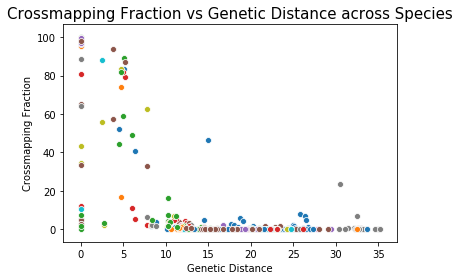

In [6]:
import glob
path = "/media/MassStorage/tmp/TE/honours/analysis/Alignment/*/*/match_distribution.csv"
path_names = glob.glob(path)
for path in path_names:
    template_frame = pd.DataFrame(data=None, columns = ['Species Name','Genetic Distance','Crossmapping Fraction'])
    if path[71:-23] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            match_dist = pd.read_csv(path, header=0)
            for element in match_dist.index:
#                 print(match_dist.at[element,'analysis/Consensus/'+path[53:-22]][19:-1])
#                 print(match_dist.at[element,'Percentage Match'])
                tmp = pd.DataFrame(data=[[phylogeny[match_dist.at[element,'analysis/Consensus/'+path[53:-22]][19:-1]],None,match_dist.at[element,'Percentage Match']]],columns=['Species Name','Genetic Distance','Crossmapping Fraction'])
                template_frame = template_frame.append(tmp,ignore_index=True)
            template_frame = template_frame.set_index('Species Name')
            for element in template_frame.index:
                if np.isnan(large_frame.at[element,phylogeny[path[53:-23]]]):
                    template_frame.at[element,'Genetic Distance'] = 0
                else:
                    template_frame.at[element,'Genetic Distance'] = 100-large_frame.at[element,phylogeny[path[53:-23]]]
            figures = sns.scatterplot(x=template_frame['Genetic Distance'],y=template_frame['Crossmapping Fraction'])
            figures.set_title("Crossmapping Fraction vs Genetic Distance across Species", fontsize=15)
            ax = figures.get_figure()
            ax.savefig("../../analysis/Stats/crossmapvsgendist.png")

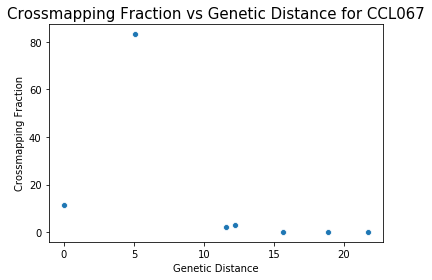

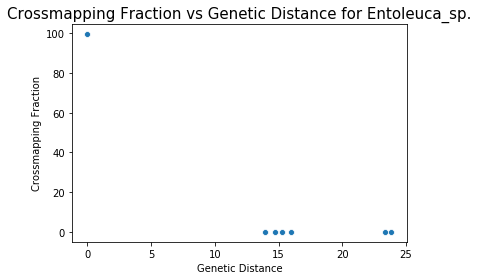

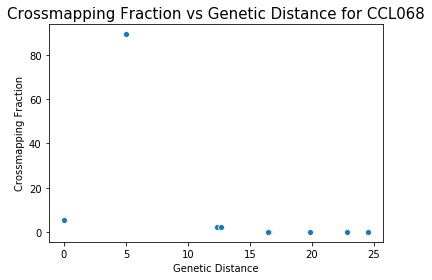

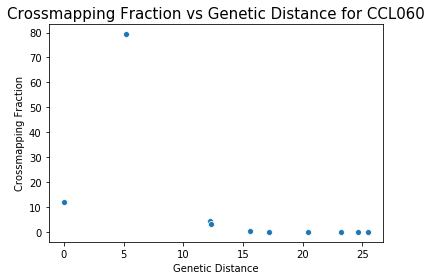

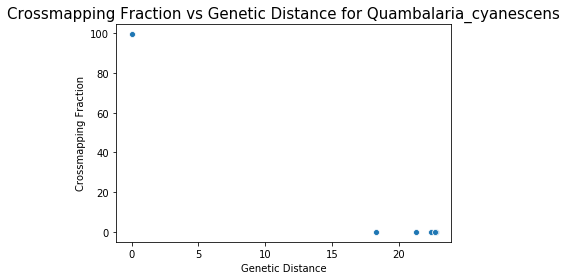

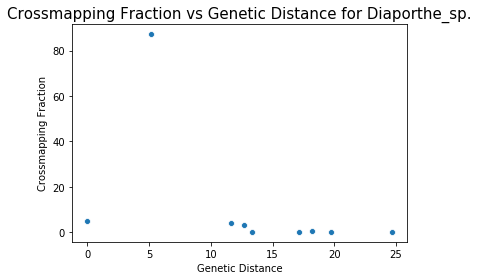

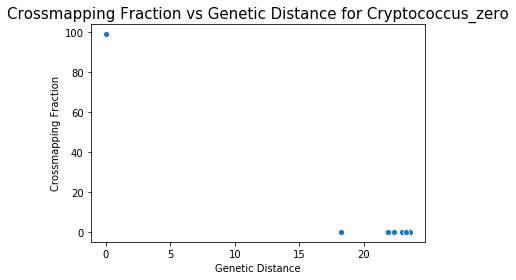

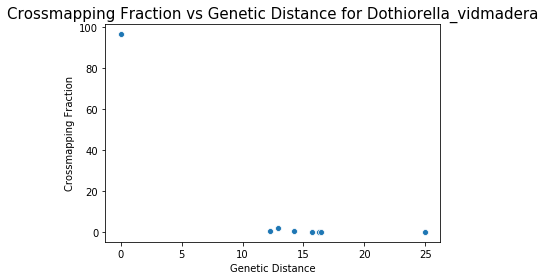

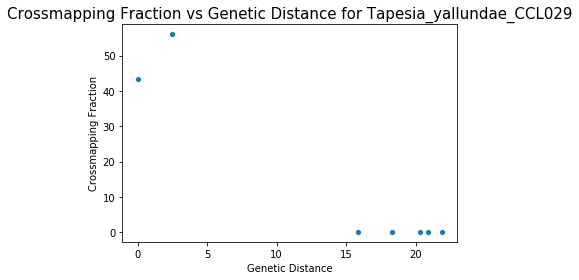

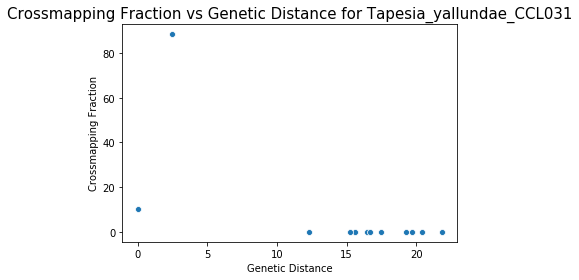

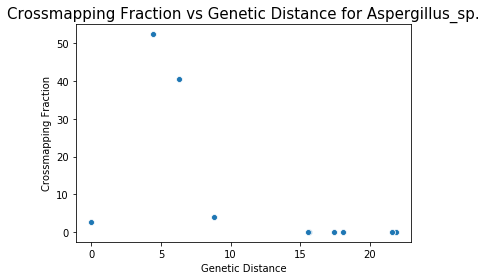

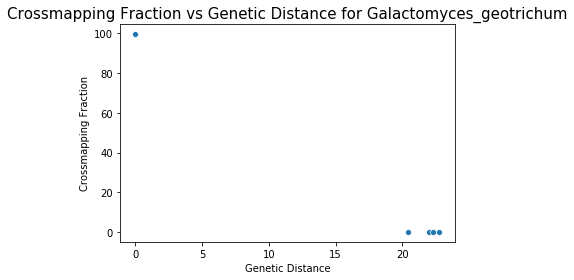

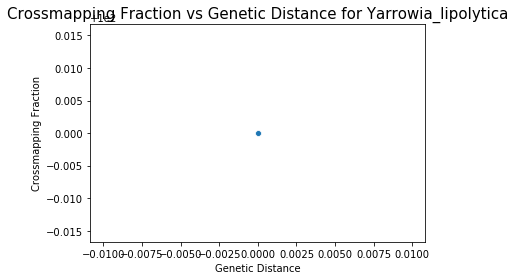

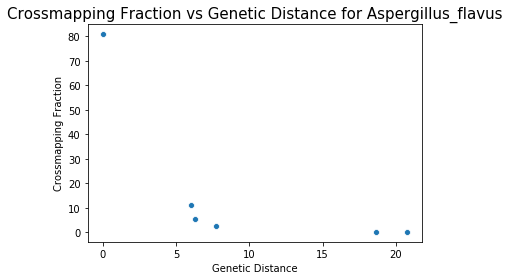

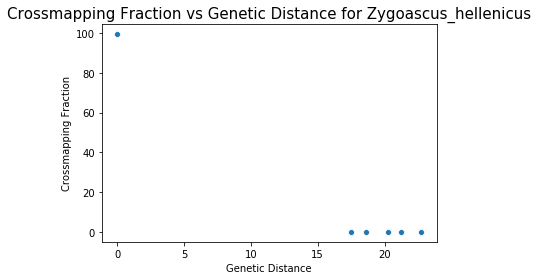

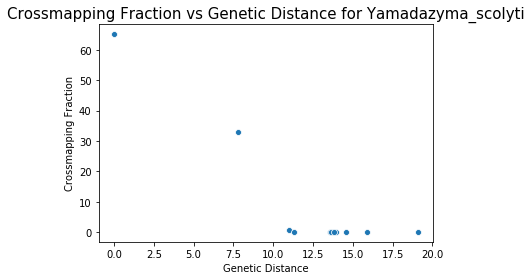

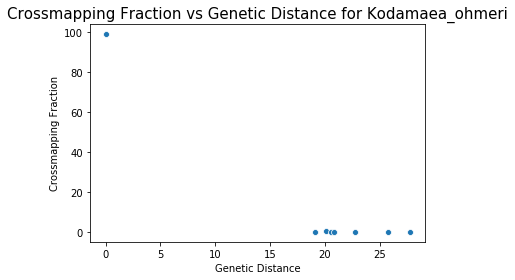

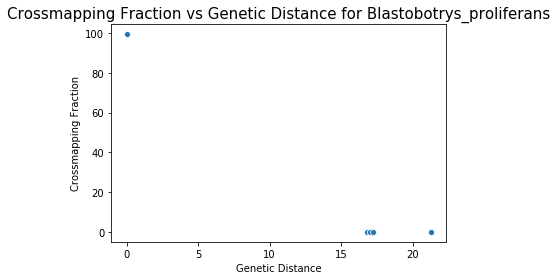

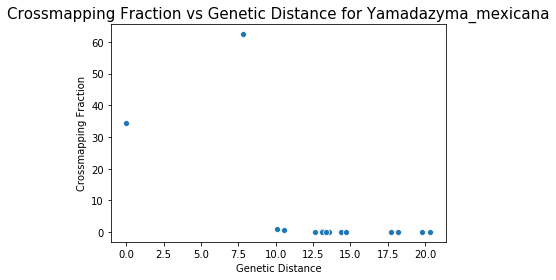

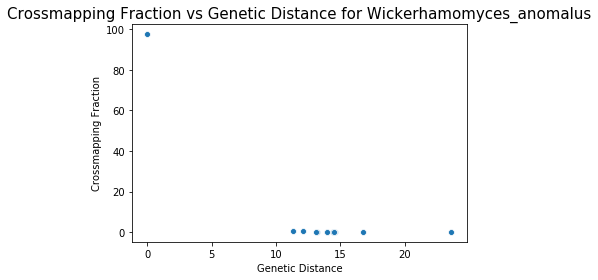

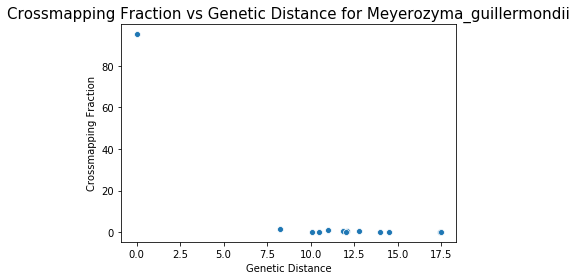

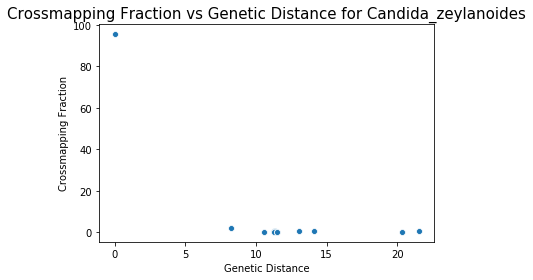

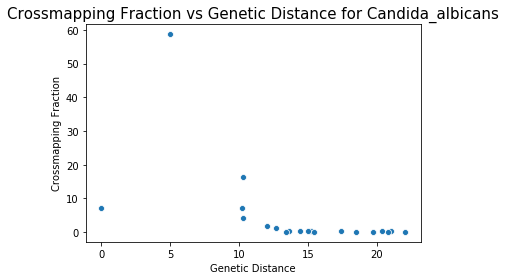

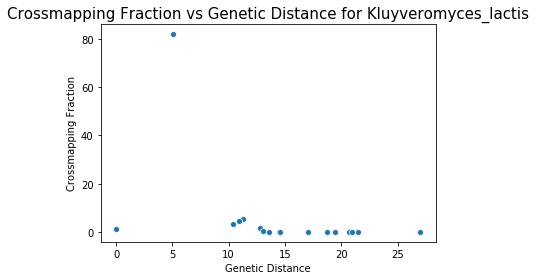

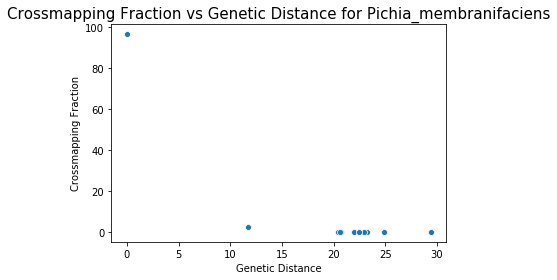

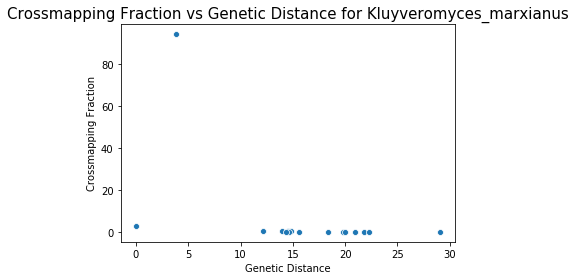

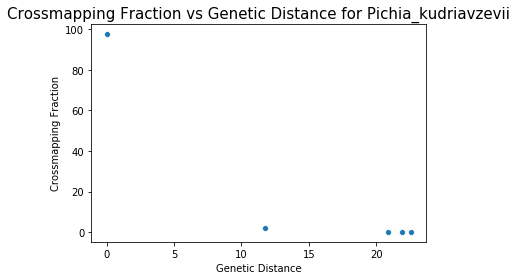

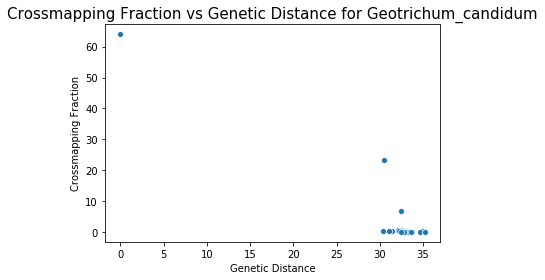

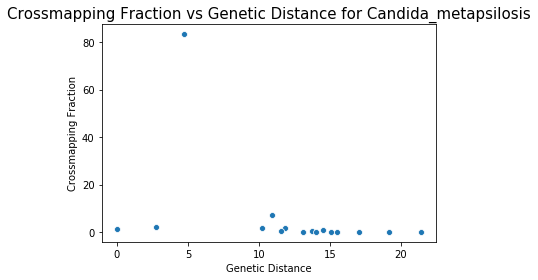

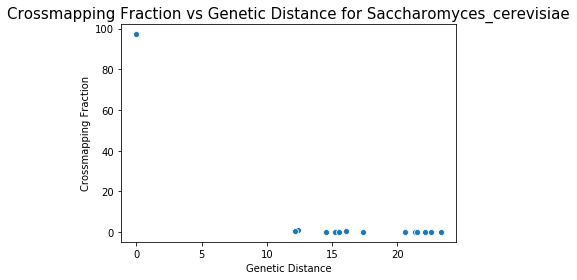

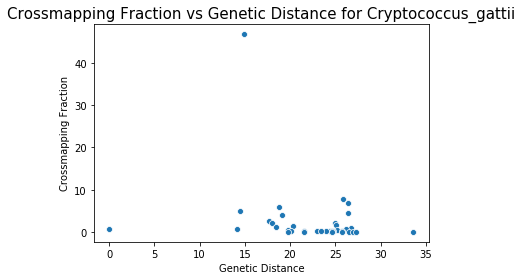

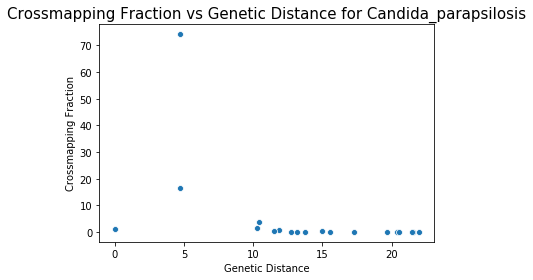

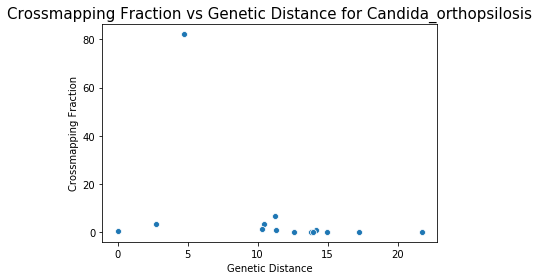

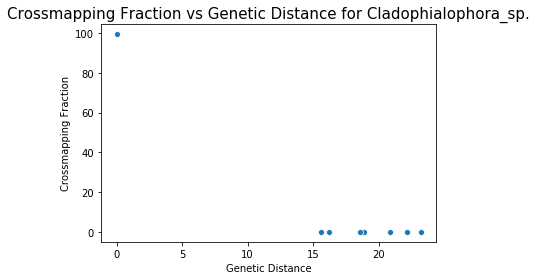

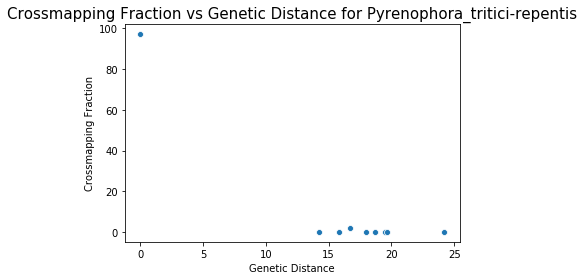

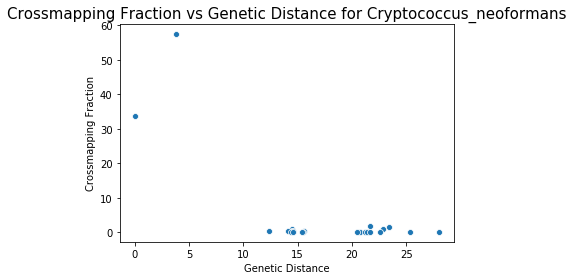

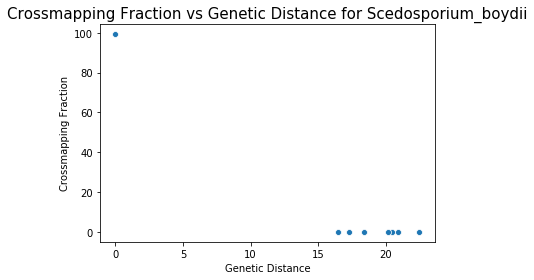

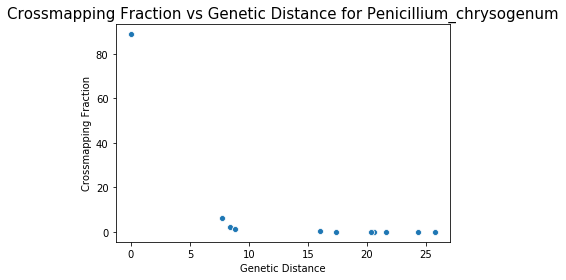

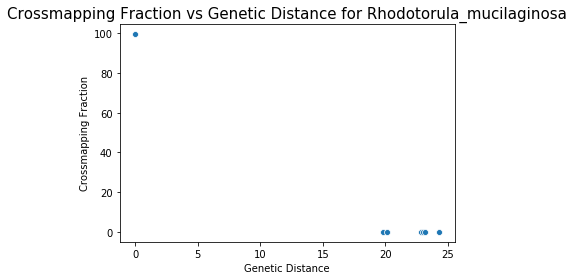

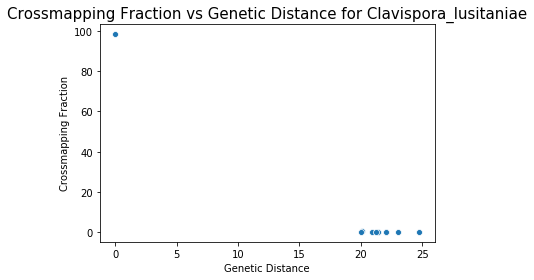

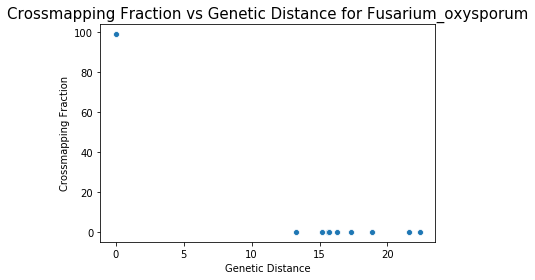

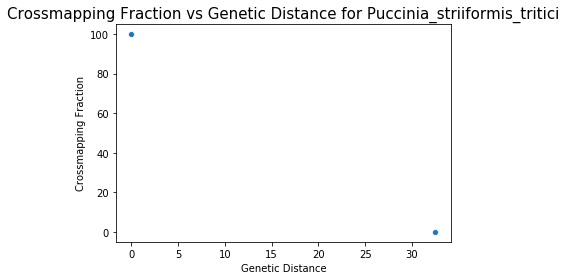

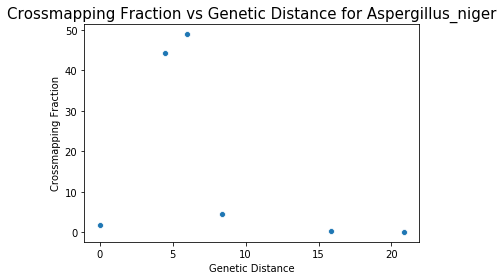

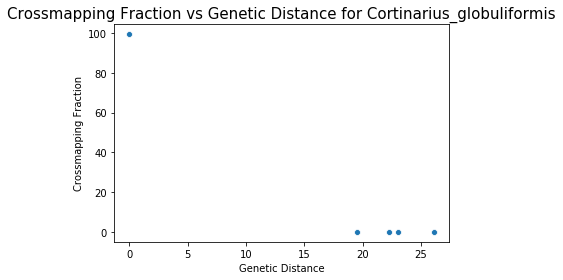

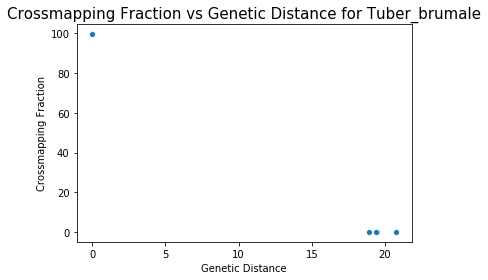

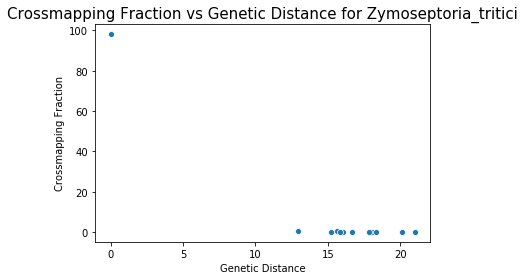

In [7]:
import glob
path = "/media/MassStorage/tmp/TE/honours/analysis/Alignment/*/*/match_distribution.csv"
path_names = glob.glob(path)
for path in path_names:
    template_frame = pd.DataFrame(data=None, columns = ['Species Name','Genetic Distance','Crossmapping Fraction'])
    if path[71:-23] != 'unclassified':
        if '20171212_FAH18688/barcode10' not in path and '20171207_FAH18654/barcode10' not in path:
            match_dist = pd.read_csv(path, header=0)
            for element in match_dist.index:
#                 print(match_dist.at[element,'analysis/Consensus/'+path[53:-22]][19:-1])
#                 print(match_dist.at[element,'Percentage Match'])
                tmp = pd.DataFrame(data=[[phylogeny[match_dist.at[element,'analysis/Consensus/'+path[53:-22]][19:-1]],None,match_dist.at[element,'Percentage Match']]],columns=['Species Name','Genetic Distance','Crossmapping Fraction'])
                template_frame = template_frame.append(tmp,ignore_index=True)
            template_frame = template_frame.set_index('Species Name')
            for element in template_frame.index:
                if np.isnan(large_frame.at[element,phylogeny[path[53:-23]]]):
                    template_frame.at[element,'Genetic Distance'] = 0
                else:
                    template_frame.at[element,'Genetic Distance'] = 100-large_frame.at[element,phylogeny[path[53:-23]]]
            plt.figure()
            figures = sns.scatterplot(x=template_frame['Genetic Distance'],y=template_frame['Crossmapping Fraction'])
            figures.set_title("Crossmapping Fraction vs Genetic Distance for " + phylogeny[path[53:-23]], fontsize=15)
            plt.show()
            plt.close()

Draw line with nearest neighbour


Draw in facet plot based on nearest neighbour?


Color-code dots by genus?

In [66]:
%%writefile ../generate_summary_dataframe.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse

parser = argparse.ArgumentParser(description="""
Enter the analysis directory to generate a dataframe that extracts the details
for each sample
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_directory", help="Run from honours folder and input analysis/")
args = parser.parse_args()

phylogeny = {'20171103_FAH15473/barcode01': 'k__Fungi;p__Basidiomycota;c__Pucciniomycetes;o__Pucciniales;f__Pucciniaceae;g__Puccinia;s__striiformis-tritici',
             '20171103_FAH15473/barcode02': 'k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Capnodiales;f__Mycosphaerellaceae;g__Zymoseptoria;s__tritici',
             '20171103_FAH15473/barcode03': 'k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Pleosporaceae;g__Pyrenophora;s__tritici-repentis',
             '20171103_FAH15473/barcode04': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Hypocreales;f__Nectriaceae;g__Fusarium;s__oxysporum',
             '20171103_FAH15473/barcode05': 'k__Fungi;p__Ascomycota;c__Pezizomycetes;o__Pezizales;f__Tuberaceae;g__Tuber;s__brumale',
             '20171103_FAH15473/barcode06': 'k__Fungi;p__Basidiomycota;c__Agaricomyctes;o__Agaricales;f__Cortinariaceae;g__Cortinarius;s__globuliformis',
             '20171103_FAH15473/barcode07': 'k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Trichocomaceae;g__Aspergillus;s__niger',
             '20171103_FAH15473/barcode08': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Metschnikowiaceae;g__Clavispora;s__lusitaniae',
        '20171103_FAH15473/barcode09': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Kluyveromyces;s__unidentified', # formerly Cryptococcus neoformans, matched in both UNITE and tree to Kluyveromyces
             '20171103_FAH15473/barcode10': 'k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Trichocomaceae;g__Penicillium;s__chrysogenum',
             '20171103_FAH15473/barcode11': 'k__Fungi;p__Basidiomycota;c__Microbotryomycetes;o__Sporidiobolales;f__Sporidiobolaceae;g__Rhodotorula;s__mucilaginosa',
             '20171103_FAH15473/barcode12': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Microascales;f__Microascaceae;g__Scedosporium;s__boydii',
             '20171207_FAH18654/barcode01': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Trichomonascaceae;g__Blastobotrys;s__proliferans', # matches Sugiyamella novakii in UNITE
             '20171207_FAH18654/barcode02': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Debaryomycetaceae;g__Debaryomyces;s__unidentified', # formerly Candida zeylanoides, matched in both UNITE and tree as Debaryomces/Meyerozyma
        '20171207_FAH18654/barcode03': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Dipodascaceae;g__Galactomyces;s__geotrichum', # tree puts it further away from other samples of its type, UNITE calls it Dipodascus
                                     # May have larger issues with Geotrichum candidum - maybe leave out?
             '20171207_FAH18654/barcode04': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Metschnikowiaceae;g__Kodamaea;s__ohmeri',
             '20171207_FAH18654/barcode05': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Debaryomycetaceae;g__Meyerozyma;s__guillermondii',
             '20171207_FAH18654/barcode06': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Phaffomycetaceae;g__Wickerhamomyces;s__anomalus',
             '20171207_FAH18654/barcode07': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Debaryomycetaceae;g__Yamadazyma;s__mexicana',
             '20171207_FAH18654/barcode08': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Debaryomycetaceae;g__Yamadazyma;s__scolyti',
             '20171207_FAH18654/barcode09': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Dipodascaceae;g__Yarrowia;s__lipolytica',
             '20171207_FAH18654/barcode11': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Trichomonascaceae;g__Zygoascus;s__hellenicus', # matches Sugiyamella novakii in UNITE
             '20171207_FAH18654/barcode12': 'k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Trichocomaceae;g__Aspergillus;s__flavus',
             
             '20171212_FAH18688/barcode01': 'k__Fungi;p__Basidiomycetes;c__Tremellomycetes;o__Tremellales;f__Tremellaceae;g__Cryptococcus;s__zero',
             '20171212_FAH18688/barcode02': 'k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Trichocomaceae;g__Aspergillus;s__unidentified',
         '20171212_FAH18688/barcode03': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Diaporthales;f__Diaporthaceae;g__Diaporthe;s__CCL067',
             '20171212_FAH18688/barcode04': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Diaporthales;f__Diaporthaceae;g__Diaporthe;s__unidentified',
             '20171212_FAH18688/barcode05': 'k__Fungi;p__Ascomycota;c__Leotiomycetes;o__Helotiales;f__Dermateaceae;g__Oculimacula;s__yallundae-CCL031',
             '20171212_FAH18688/barcode06': 'k__Fungi;p__Ascomycota;c__Leotiomycetes;o__Helotiales;f__Dermateaceae;g__Oculimacula;s__yallundae-CCL029',
             '20171212_FAH18688/barcode07': 'k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Botryosphaeriales;f__Botryosphaeriaceae;g__Dothiorella;s__vidmadera',
             '20171212_FAH18688/barcode08': 'k__Fungi;p__Basidiomycota;c__Exobasidiomycetes;o__Microstromatales;f__Quambalariaceae;g__Quambalaria;s__cyanescens',
             '20171212_FAH18688/barcode09': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Xylariales;f__Xylariaceae;g__Entoleuca;s__unidentified',
                 '20171212_FAH18688/barcode11': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Diaporthales;f__Gnomoniaceae;g__Asteroma;s__CCL060', # may be asteroma or Diaporthe
                 '20171212_FAH18688/barcode12': 'k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Diaporthales;f__Gnomoniaceae;g__Asteroma;s__CCL068',
             '20180108_FAH18647/barcode01': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Saccharomyces;s__cerevisiae',
             '20180108_FAH18647/barcode02': 'k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales;f__Herpotrichiellaceae;g__Cladophialophora;s__unidentified',
             '20180108_FAH18647/barcode03': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Candida;s__albicans',
             '20180108_FAH18647/barcode04': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Candida;s__metapsilosis',
             '20180108_FAH18647/barcode05': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Candida;s__orthopsilosis',
             '20180108_FAH18647/barcode06': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Candida;s__parapsilosis',
#          '20180108_FAH18647/barcode07': 'k__Fungi;p__Basidiomycetes;c__Tremellomycetes;o__Tremellales;f__Tremellaceae;g__Cryptococcus;s__gattii', # not matching in the tree
#              '20180108_FAH18647/barcode08': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Dipodascaceae;g__Geotrichum;s__candidum', # !!! issues with UNITE search - basically bad matches
             '20180108_FAH18647/barcode09': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Candida;s__unidentified', # formerly Kluyveromyces lactis
             '20180108_FAH18647/barcode10': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Saccharomycetaceae;g__Kluyveromyces;s__marxianus',
             '20180108_FAH18647/barcode11': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Pichiaceae;g__Pichia;s__kudriavzevii',
             '20180108_FAH18647/barcode12': 'k__Fungi;p__Ascomycota;c__Saccharomycetes;o__Saccharomycetales;f__Pichiaceae;g__Pichia;s__membranifaciens'}

summary = pd.DataFrame(data=None, columns = ['species','genus','family','order','class','phylum','kingdom','# raw reads','# reads after homology filtering','# reads after length filtering','path to raw reads','path to homology filtering','path to length filtering'])
import glob
path = "/media/MassStorage/tmp/TE/honours/analysis/Consensus/*/*/"
path_names = glob.glob(path)
for path in path_names:
    if path[-13:-1] != 'unclassified' and path[-28:-1] != '20171207_FAH18654/barcode10' and path[-28:-1] != '20171212_FAH18688/barcode10':
        key = path[-28:-1]
        if args.verbose:
            print('\033[0;34m' + "Opened barcode " + '\033[0;35m' + key + '\033[1;37m')
        species_ = phylogeny[key].split(';')[6].split('__')[1]
        genus_ = phylogeny[key].split(';')[5].split('__')[1]
        family_ = phylogeny[key].split(';')[4].split('__')[1]
        order_ = phylogeny[key].split(';')[3].split('__')[1]
        class_ = phylogeny[key].split(';')[2].split('__')[1]
        phylum_ = phylogeny[key].split(';')[1].split('__')[1]
        kingdom_ = phylogeny[key].split(';')[0].split('__')[1]
        
        if args.verbose:
            print('\033[1;36m' + "BEGIN RAW"'\033[1;37m')
        raw_path = "analysis/Concatenated/"+key+"/merged.fastq"
        raw_reads = SeqIO.to_dict(SeqIO.parse(raw_path, "fastq"))
        raw_count = 0
        for entry in raw_reads:
            raw_count += 1
            
        if args.verbose:
            print('\033[1;36m' + "BEGIN HOMOLOGY"+ '\033[1;37m')
        homology_path = "analysis/Python_Processing/"+key+"/combined_test.paf"
        homology_paf = pd.read_csv(homology_path, sep='\t', header=None, engine='python')
        homology_reads = {}
        homology_count = 0
        for entry in homology_paf[0].unique():
            homology_count += 1
            
        if args.verbose:
            print('\033[1;36m' + "BEGIN LENGTH" + '\033[1;37m')
        length_path = "analysis/Length_Filtered/"+key+"/length_restricted_reads.fasta"
        length_reads = SeqIO.to_dict(SeqIO.parse(length_path, "fasta"))
        length_count = 0
        for entry in length_reads:
            length_count += 1


        add = pd.DataFrame([[species_, genus_, family_, order_, class_, phylum_, kingdom_, raw_count, homology_count, length_count, raw_path, homology_path, length_path]], columns = ['species','genus','family','order','class','phylum','kingdom','# raw reads','# reads after homology filtering','# reads after length filtering','path to raw reads','path to homology filtering','path to length filtering'], index=[key])
        summary = summary.append([add])
summary = summary.sort_index(axis=0)
summary.to_csv("analysis/Stats/reference_dataframe.csv")
if args.verbose:
            print('\033[0;34m' + "Reference Dataframe saved to " + '\033[0;35m' + "analysis/Stats/reference_dataframe.csv" + '\033[1;37m')

Overwriting ../generate_summary_dataframe.py


In [78]:
%%writefile ../numberfy_fasta.py

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord as SR
from Bio.Blast import NCBIXML
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
import pandas as pd
from pandas import DataFrame as df
# import seaborn as sns
import csv
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import os
from shutil import copy
import random
import warnings
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# from ipysankeywidget import SankeyWidget
warnings.filterwarnings("ignore")
import argparse


parser = argparse.ArgumentParser(description="""
This creates a machine-learning friendly version of each length restricted fasta file
""")
group = parser.add_mutually_exclusive_group()
group.add_argument("--verbose", "-v", "--v", action="store_true")
group.add_argument("--quiet", "-q", "--q", action="store_true")
parser.add_argument("input_file", help="The input file for extraction")
args = parser.parse_args()

if args.verbose:
    print("Input file is " + args.input_file + "\n")

fasta = SeqIO.to_dict(SeqIO.parse(args.input_file, "fasta"))

fasta_numbers = fasta.copy()

for key in fasta:
    seq = str(fasta[key].seq[30:-30]).replace("A",'0').replace("C",'1').replace("G",'2').replace("T",'3')
#     if len(seq) < max(total_lens):
#         seq = seq + '4'*(max(total_lens)-len(seq))
    fasta_numbers[key].seq = Seq(seq)

with open(args.input_file[:-6]+'_numbers.fasta', "w") as output_handle:
    SeqIO.write(fasta_numbers.values(), output_handle, 'fasta')

Overwriting ../numberfy_fasta.py
